In [1]:
#import needed libraries (although not all imported below are used in the given code)

import os
from os import listdir
from os.path import isfile, join

import sys
import codecs
import fileinput
import string
from collections import OrderedDict

import numpy as np

from pandas import DataFrame
import pandas as pd

import matplotlib

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import scipy
from scipy import optimize, stats
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths,hilbert

from decimal import Decimal



import iminuit 


import csv
import cmath
import math
from math import sqrt




# destination to the data (input) and output folders (change according to the path on your PC)

containing_folder_path = "/home/mfedkevych/Work/LZ/"
path_base = containing_folder_path + "2022-11-17_GeIII_calibration_Th228_new/"
measurement_path= path_base +'Data/'
measurement_output_path= path_base + 'Results/'

#calibration parameters
p0 = -3.617
p1 = 2.878

#function to count number of significant digits after comma
def number_sigdigs(x):
    digs_after_comma = str(x - math.floor(x))
    digs_after_comma = digs_after_comma[2:]
    number=0
    for c in digs_after_comma:
        if c=='0':
            number+=1
        else:
            number+=2
            break
    return number

print('numpy version', np.__version__)
print('matplotlib version', matplotlib.__version__)
print('pandas version', pd.__version__)
print('scipy version', scipy.__version__)
print('iminuit version', iminuit.__version__)

numpy version 1.25.1
matplotlib version 3.7.2
pandas version 2.0.3
scipy version 1.11.1
iminuit version 2.22.0


In [2]:
# read the data files from measurement_path folder and replace "," delimiter with "."

files_in_folder = [f for f in listdir (measurement_path) if isfile(join(measurement_path, f))]
files_in_folder.sort()



In [3]:
# read the data files and put the content into list of dataframes

numbers=np.linspace(0,8191,num=8192)
numbers=list(numbers)

import re

scan = [] #list of measurement data (in DataFrame format) extracted from scan files
files_scan=[] #list of measurement files

for f in files_in_folder:
    if "Th228Calibration_with_attenuator" in f: #choose only files with names containing "Th228Calibration_with_attenuator"
        
        print(f) #prints measurement file name
        files_scan.append(f) #choose only files with names containing "Th228Calibration_with_attenuator"
        


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list
        
for f in files_in_folder:        
    if "Background" in f: #choose only files with names containing "Background"
        
        print(f) #prints measurement file name
        files_scan.append(f) #choose only files with names containing "Background"
        


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

#Th-228 measurement time and background measurement time
t=354.76
t_bkg=9*86400 +61990.16  

#combine background data
bkg = np.asarray(scan[1][1])
i=2
while i <len(scan):
    bkg+=np.asarray(scan[i][1])
    i+=1

#rescale background data to Th-228 measurement time
bkg=bkg/t_bkg*t

#subtract rescaled background from Th-228 data
signal=np.asarray(scan[0][1])-bkg


Th228Calibration_with_attenuator_new.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20221118_Background_00_000.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20221118_Background_00_001.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20221118_Background_00_002.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20221118_Background_00_003.dat
         0  1
0        0  0
1        1  0
2        2  0
3      

In [4]:
#checking that the measurement files have been read and written in the right order

i=0
while i<len(files_scan):
    print(i, files_scan[i])
    i+=1


0 Th228Calibration_with_attenuator_new.dat
1 20221118_Background_00_000.dat
2 20221118_Background_00_001.dat
3 20221118_Background_00_002.dat
4 20221118_Background_00_003.dat
5 20221118_Background_00_004.dat
6 20221118_Background_01_000.dat
7 20221118_Background_01_001.dat
8 20221118_Background_01_002.dat
9 20221118_Background_01_003.dat
10 20221118_Background_01_004.dat


In [5]:
Peak_name=["Pb-212", "208Tl","212Bi", "212Pb", "208Tl", "208Tl","212Bi", "208Tl","212Bi", "208Tl","212Bi","212Bi", "208Tl", "212Bi", "208Tl", "212Bi", "208Tl SE"]
Peak_energy=[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]
Peak_channel=[]
Peak_channel_err=[]
Sigma_channel=[]
Sigma_channel_err=[]

p=0

<ValueView A=343.43130988358246 sig=1.346100594856279 mu=127.01226157397443 offset=439.2169860847797>
<ErrorView A=88.07861351158623 sig=0.32627660576912515 mu=0.26944723201721843 offset=8.811374710094649>
(343.43130988358246, 1.346100594856279, 127.01226157397443, 439.2169860847797)


/tmp/ipykernel_23199/1076972369.py:214: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2438430e20> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1076972369.py:250: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1076972369.py:257: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2438430e20> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

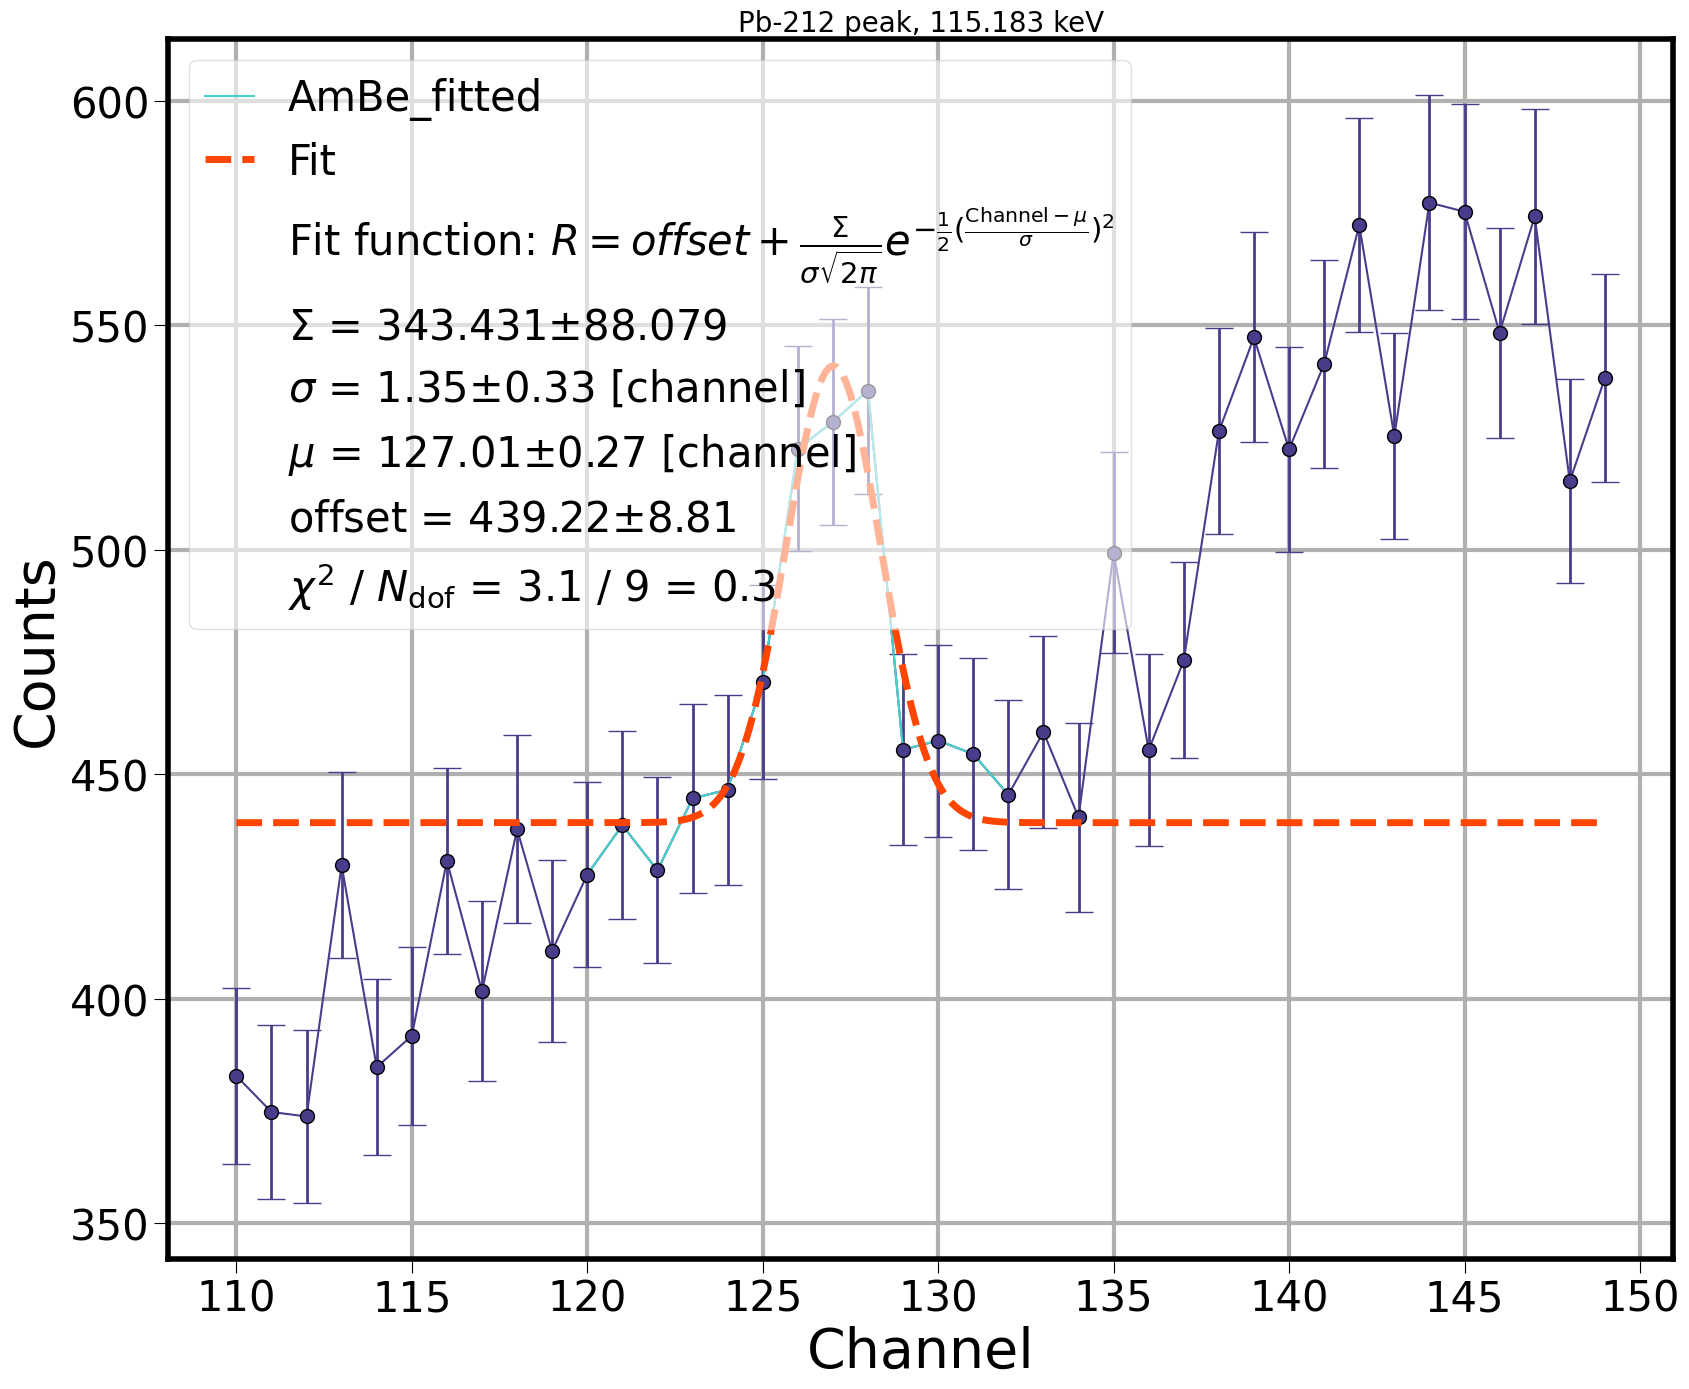

In [6]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65



from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()



ch1=120
ch2=133
ch3=110
ch4=150

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 127
sig00 = 5 
offset00 = 300

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    



#run minimization  
minuit.migrad()

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 277.371 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.533 (χ²/ndof = 0.5)      │              Nfcn = 125              │
│ EDM = 4.17e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    970    │    60     │            │            │         │         │       │
│ 1 │ sig    │   1.36    │   0.08    │            │            │         │         │       │
│ 2 │ mu     │  307.11   │   0.08    │            │            │         │         │       │
│ 3 │ offset │    173    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 3.52e+03    2.637    0.124     -170 │
│    sig │    2.637  0.00641    0.000   -0.176 │
│     mu │    0.124    0.000  0.00596   -0.008 │
│ offset │     -170   -0.176   -0.008     22.9 │
└────────┴─────────────────────────────────────┘

<ValueView A=970.5852252059741 sig=1.3611877733912177 mu=307.10603940673855 offset=173.18249029568196>
<ErrorView A=59.29718738795904 sig=0.08008031477630356 mu=0.07721034375197179 offset=4.781293945141644>
(970.5852252059741, 1.3611877733912177, 307.10603940673855, 173.18249029568196)


/tmp/ipykernel_23199/1663484597.py:214: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24358248b0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1663484597.py:250: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1663484597.py:257: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24358248b0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

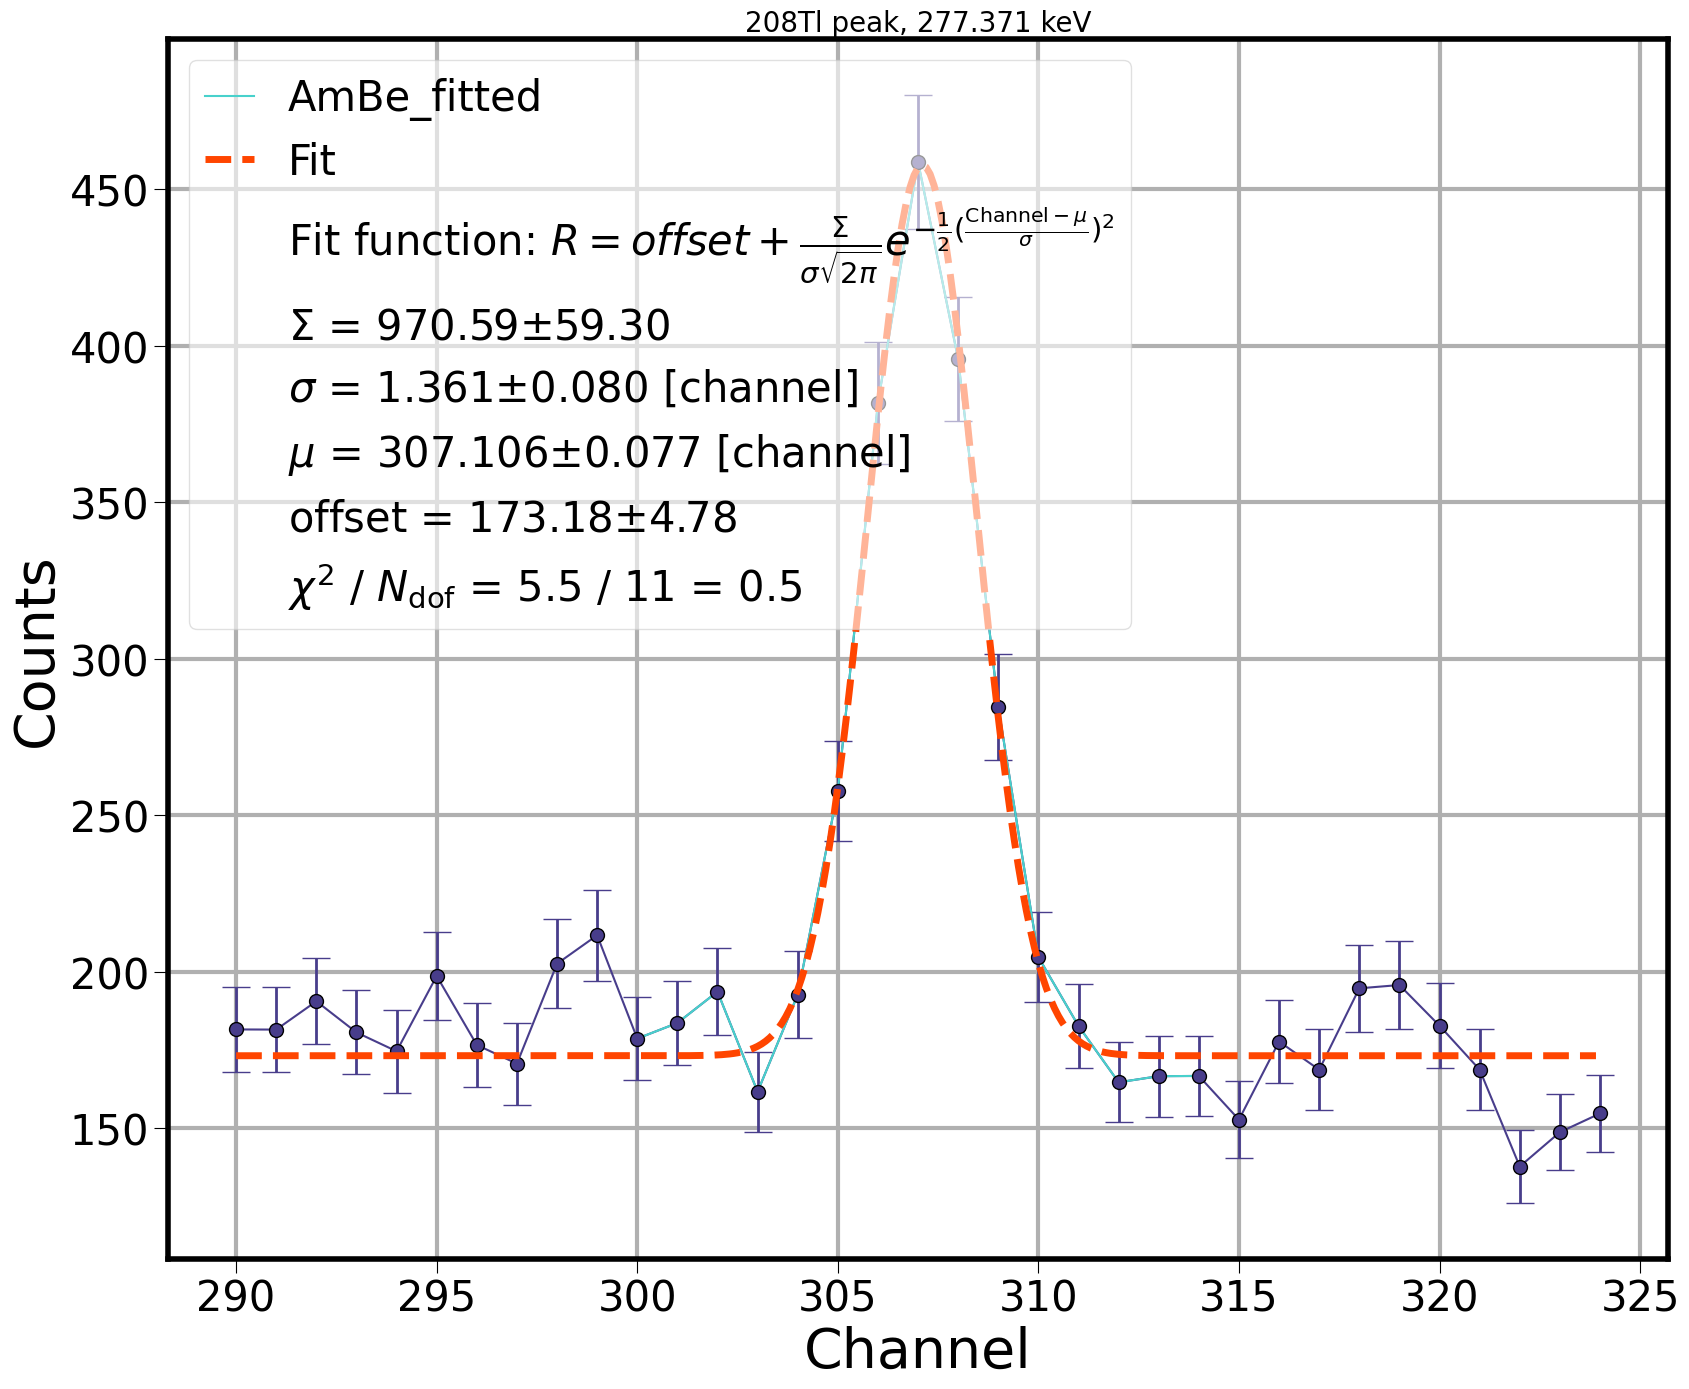

In [7]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()




ch1=300
ch2=315
ch3=290
ch4=325

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 307
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 288.2 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.992 (χ²/ndof = 0.8)      │              Nfcn = 620              │
│ EDM = 5.17e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    130    │    50     │            │            │         │         │       │
│ 1 │ sig    │    1.3    │    0.4    │            │            │         │         │       │
│ 2 │ mu     │   318.6   │    0.4    │            │            │         │         │       │
│ 3 │ offset │    157    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 2.31e+03    13.37    -5.33     -168 │
│    sig │    13.37    0.176    -0.07    -1.03 │
│     mu │    -5.33    -0.07    0.183     0.41 │
│ offset │     -168    -1.03     0.41       25 │
└────────┴─────────────────────────────────────┘

<ValueView A=134.4634204226547 sig=1.3002016218856982 mu=318.63043203290283 offset=156.85911928425645>
<ErrorView A=48.085863650151026 sig=0.42011024895100746 mu=0.4280281968798022 offset=4.995269599847467>
(134.4634204226547, 1.3002016218856982, 318.63043203290283, 156.85911928425645)


/tmp/ipykernel_23199/1366134054.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2434276590> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1366134054.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1366134054.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2434276590> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

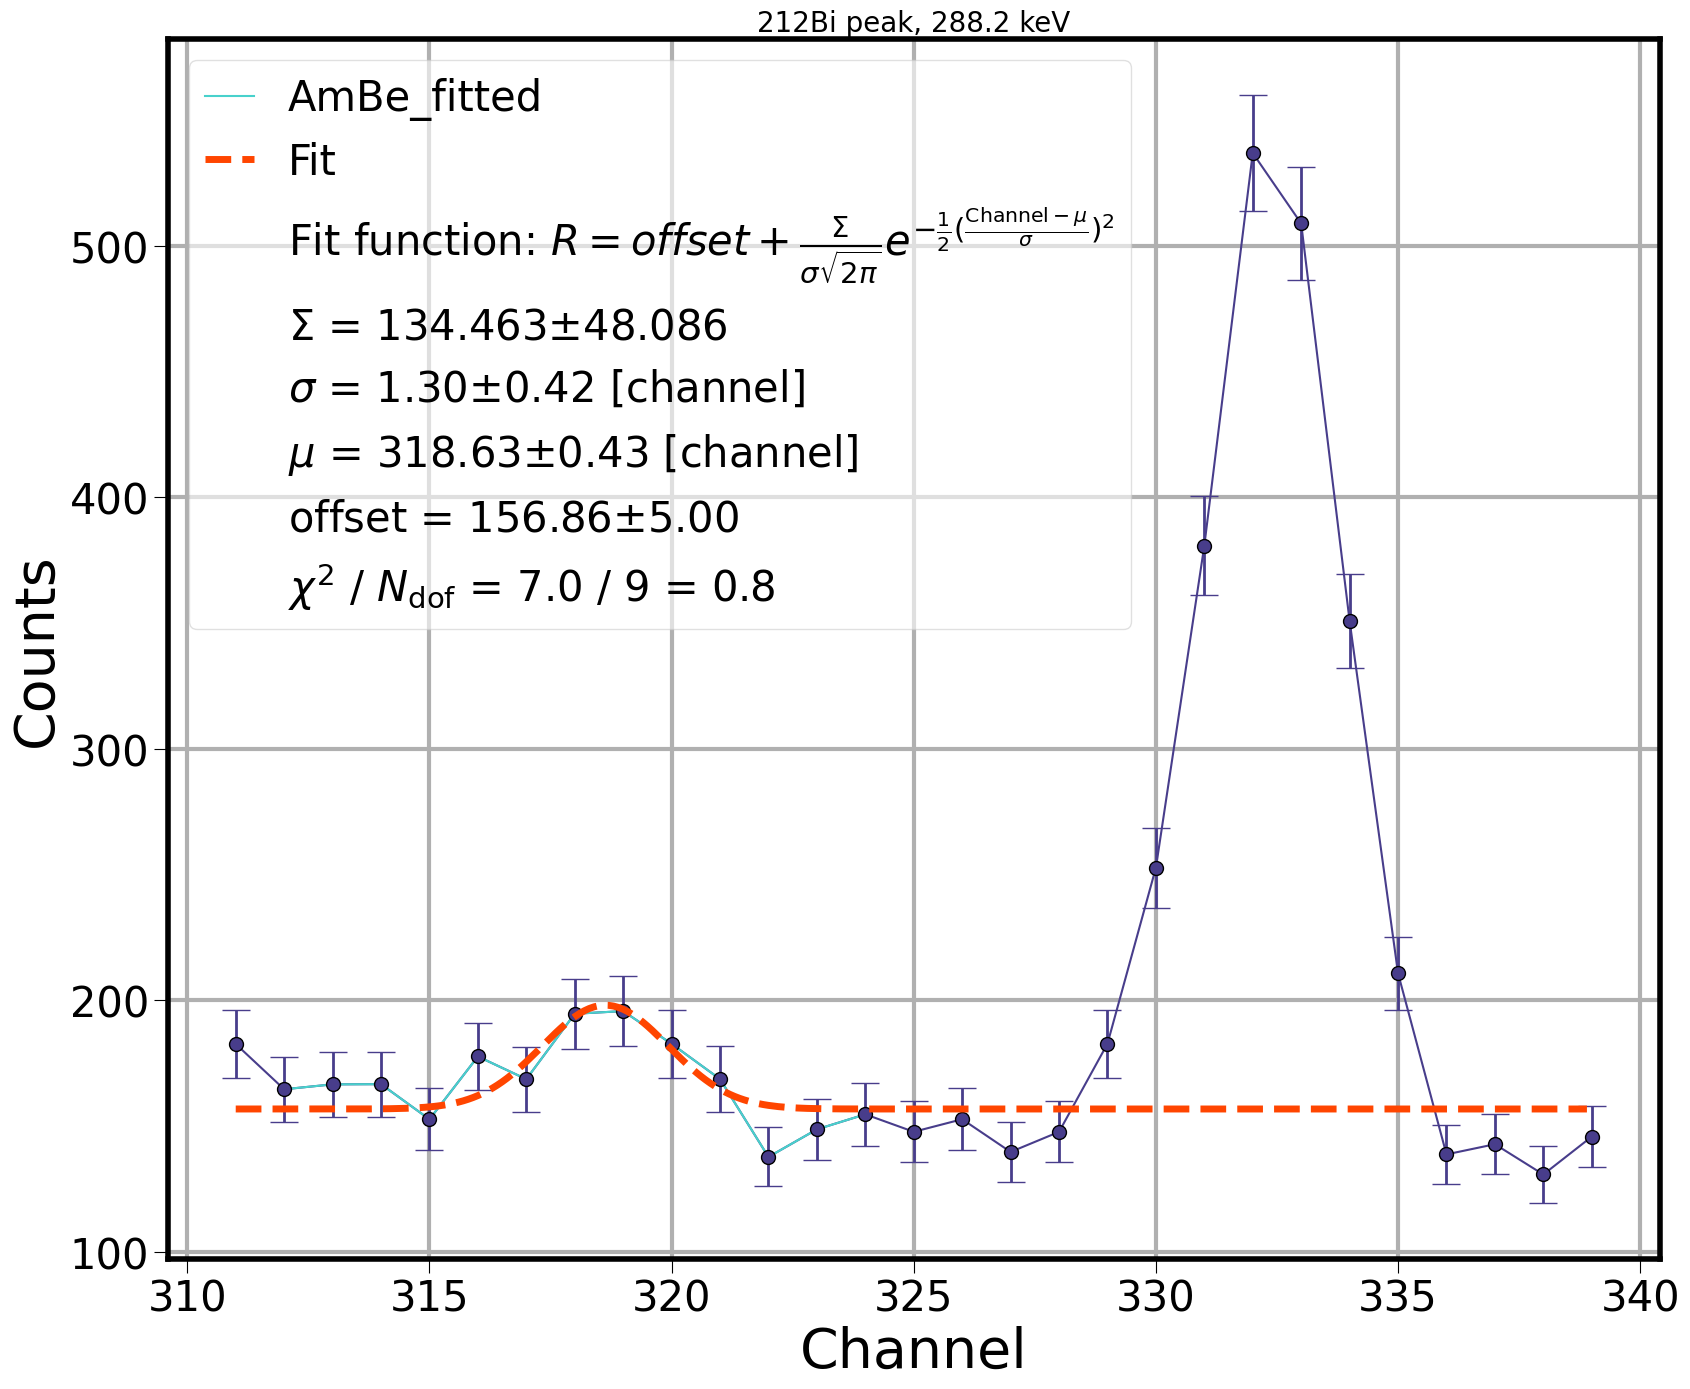

In [8]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=312
ch2=325
ch3=311
ch4=340

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 317
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    



#run minimization  
minuit.migrad()


#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Pb peak, 300.087 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.052 (χ²/ndof = 0.6)      │              Nfcn = 134              │
│ EDM = 1.38e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.43e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ sig    │   1.42    │   0.06    │            │            │         │         │       │
│ 2 │ mu     │  332.34   │   0.06    │            │            │         │         │       │
│ 3 │ offset │    142    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 3.81e+03   1.8790  -0.1721     -158 │
│    sig │   1.8790  0.00354  -0.0004  -0.1253 │
│     mu │  -0.1721  -0.0004  0.00333   0.0115 │
│ offset │     -158  -0.1253   0.0115       20 │
└────────┴─────────────────────────────────────┘

<ValueView A=1432.5110427363395 sig=1.4207628290766912 mu=332.3438842948281 offset=142.0399302077767>
<ErrorView A=61.7252249712755 sig=0.0595190532650856 mu=0.0577053227834946 offset=4.476075315905085>
(1432.5110427363395, 1.4207628290766912, 332.3438842948281, 142.0399302077767)


/tmp/ipykernel_23199/1872174116.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24343491e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1872174116.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1872174116.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24343491e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

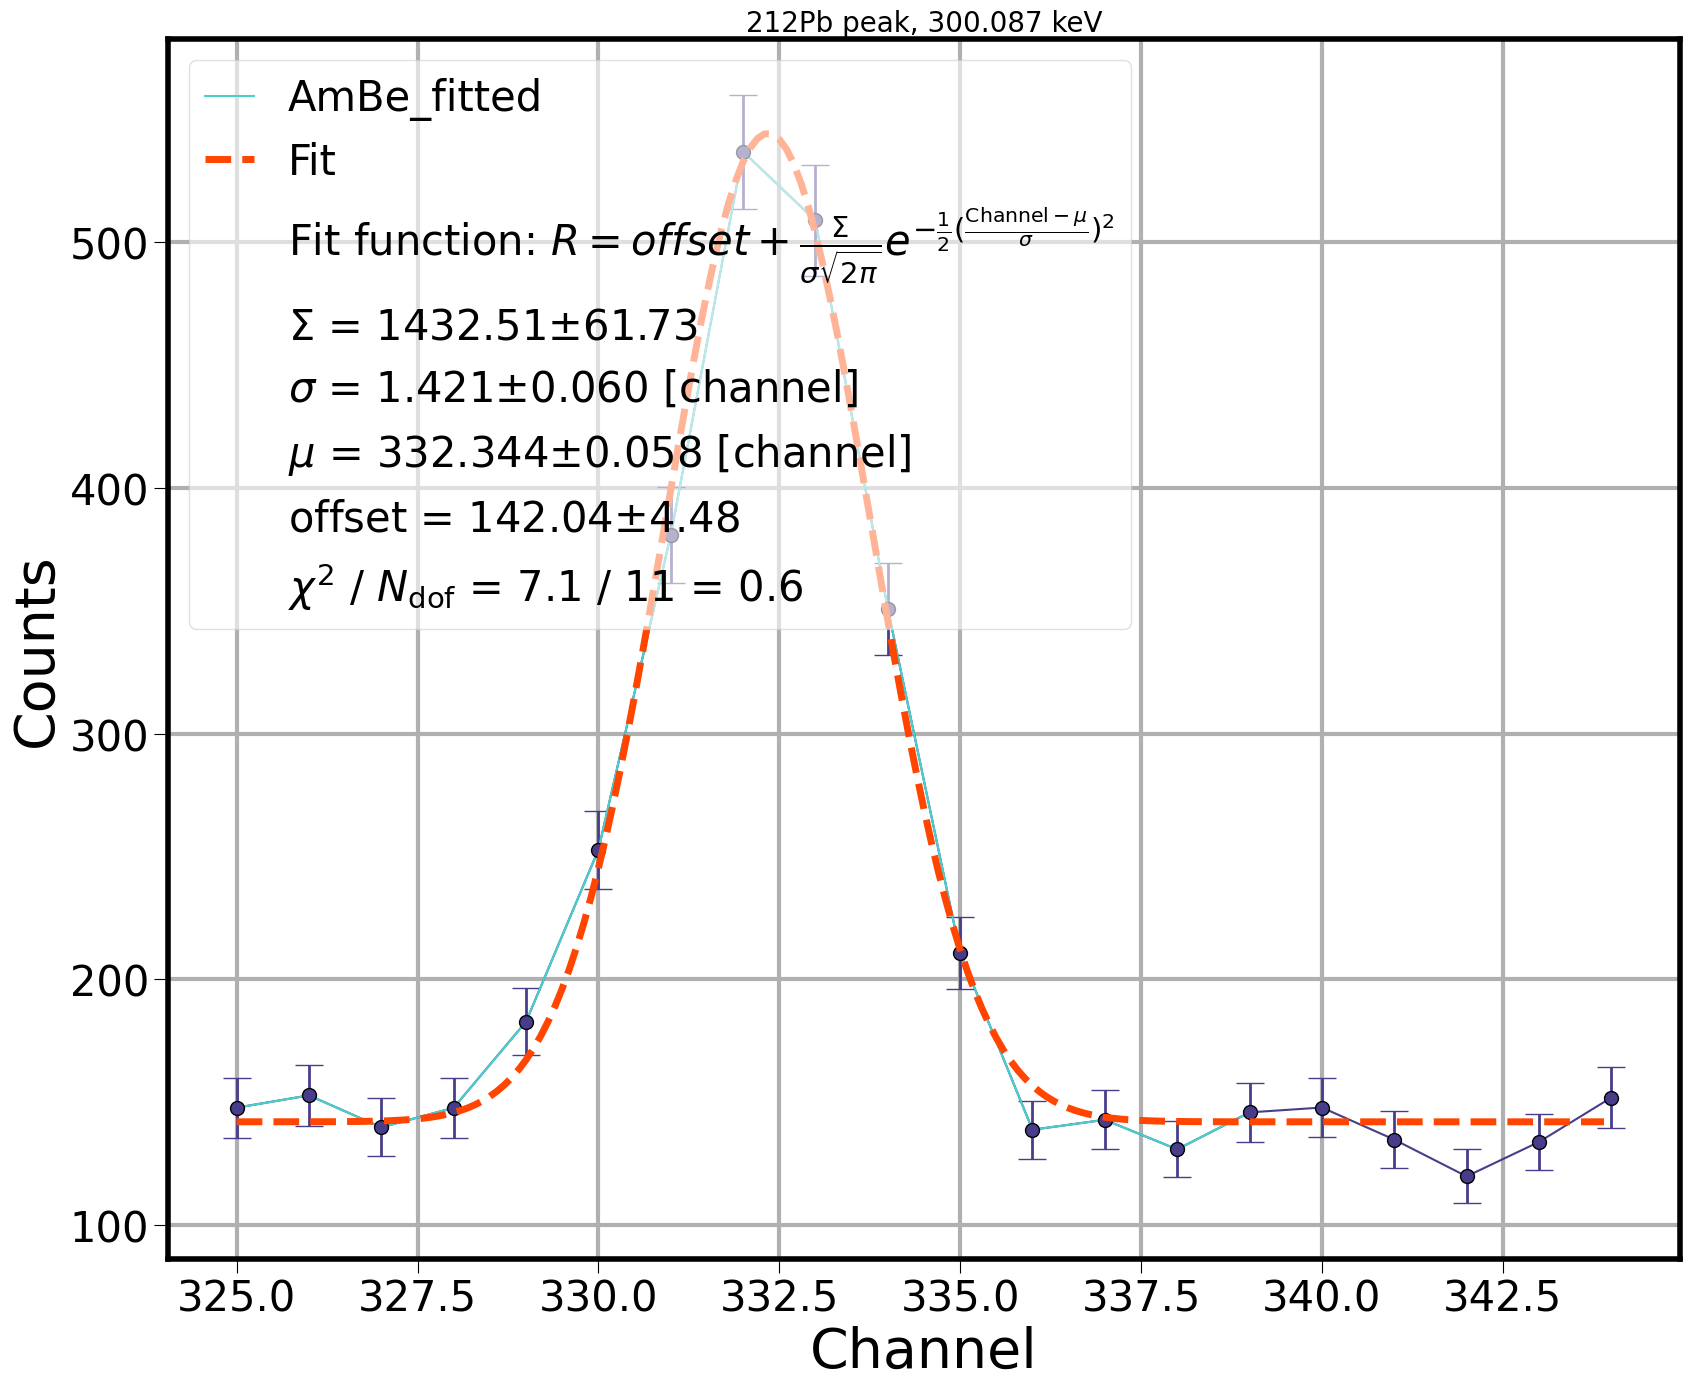

In [9]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


#plot data with errorbars
#Data_err = ax1.errorbar(scan[0], np.asarray(scan[1])*1e6, 
     #   yerr=np.asarray(scan[num][4])*1e6, fmt='o', mec='black',  mew=1, 
       # color = 'blue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

#on top plot the same data w/o errorbars with nicer markers, give name to add to the legend


ch1=325
ch2=340
ch3=325
ch4=345

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 332
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 510.69 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 303.9 (χ²/ndof = 3.2)      │              Nfcn = 147              │
│ EDM = 0.00011 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  3.20e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ sig    │   1.576   │   0.027   │            │            │         │         │       │
│ 2 │ mu     │  565.200  │   0.032   │            │            │         │         │       │
│ 3 │ offset │   46.2    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 3.68e+03 243.0e-3   0.0017     -4.8 │
│    sig │ 243.0e-3 0.000735        0  -2.4e-3 │
│     mu │   0.0017        0  0.00102  -0.0000 │
│ offset │     -4.8  -2.4e-3  -0.0000     0.51 │
└────────┴─────────────────────────────────────┘

<ValueView A=3200.018319708724 sig=1.5763030997510086 mu=565.1995708432258 offset=46.19376749134498>
<ErrorView A=60.64499606008259 sig=0.027113098357802356 mu=0.03190709848962968 offset=0.7139029052641764>
(3200.018319708724, 1.5763030997510086, 565.1995708432258, 46.19376749134498)


/tmp/ipykernel_23199/1706788083.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f243840b3d0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1706788083.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1706788083.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f243840b3d0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

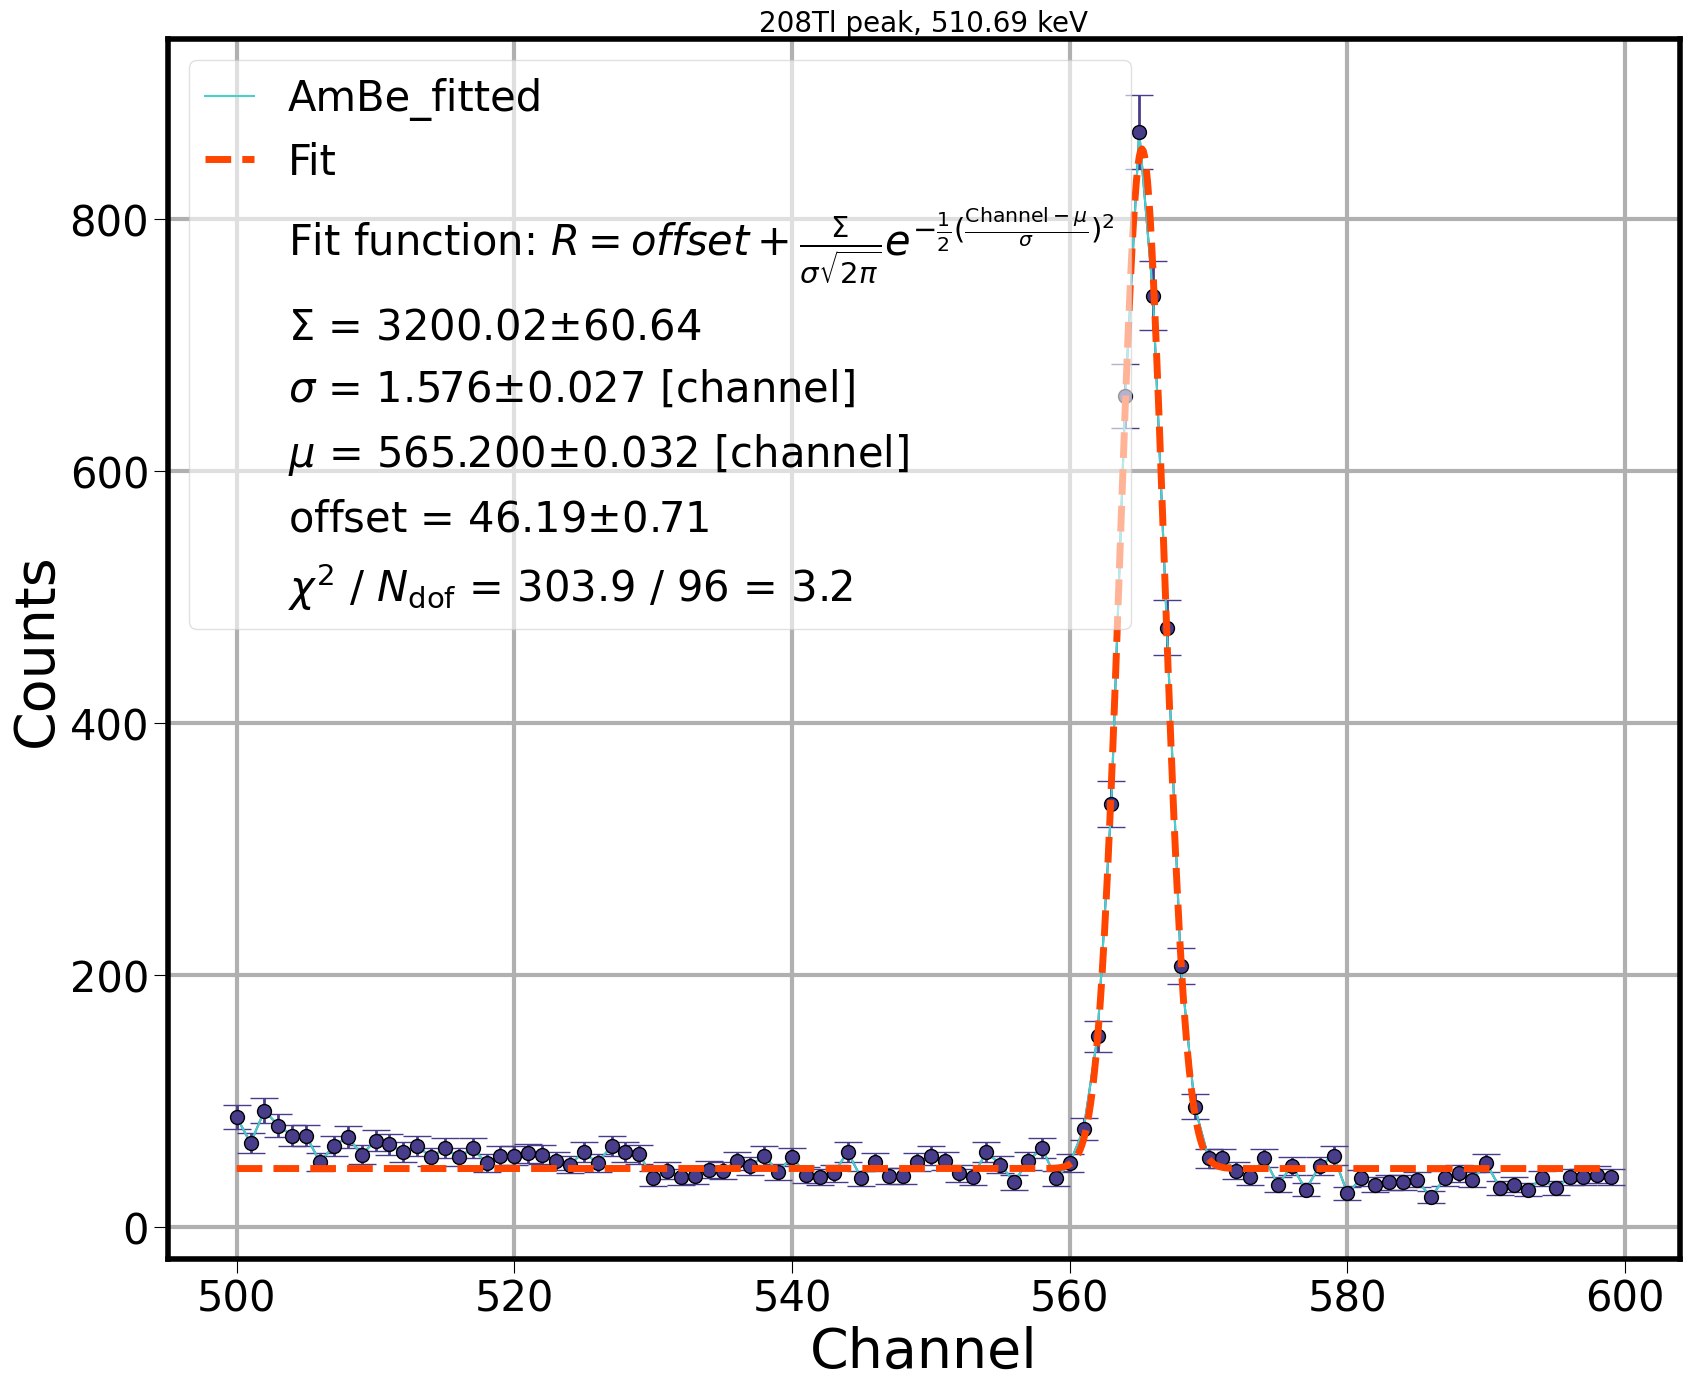

In [10]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()





ch1=500
ch2=600
ch3=500
ch4=600

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 550
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 583.191 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 255.9 (χ²/ndof = 2.7)      │              Nfcn = 110              │
│ EDM = 6.16e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │   8.7e3   │   0.1e3   │            │            │         │         │       │
│ 1 │ sig    │   1.472   │   0.014   │            │            │         │         │       │
│ 2 │ mu     │  645.179  │   0.017   │            │            │         │         │       │
│ 3 │ offset │   25.1    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  1.01e+04 -15.35e-3 -67.00e-3     -1.18 │
│    sig │ -15.35e-3  0.000192   0.02e-3  -0.62e-3 │
│     mu │ -67.00e-3   0.02e-3   0.00028  -0.11e-3 │
│ offset │     -1.18  -0.62e-3  -0.11e-3      0.28 │
└────────┴─────────────────────────────────────────┘

<ValueView A=8704.626680582938 sig=1.471856007734207 mu=645.1794158640254 offset=25.098877923110884>
<ErrorView A=100.38842623138365 sig=0.013857764290666852 mu=0.016728333694273845 offset=0.5294798986536476>
(8704.626680582938, 1.471856007734207, 645.1794158640254, 25.098877923110884)


/tmp/ipykernel_23199/2698901788.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2436260eb0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/2698901788.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/2698901788.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2436260eb0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

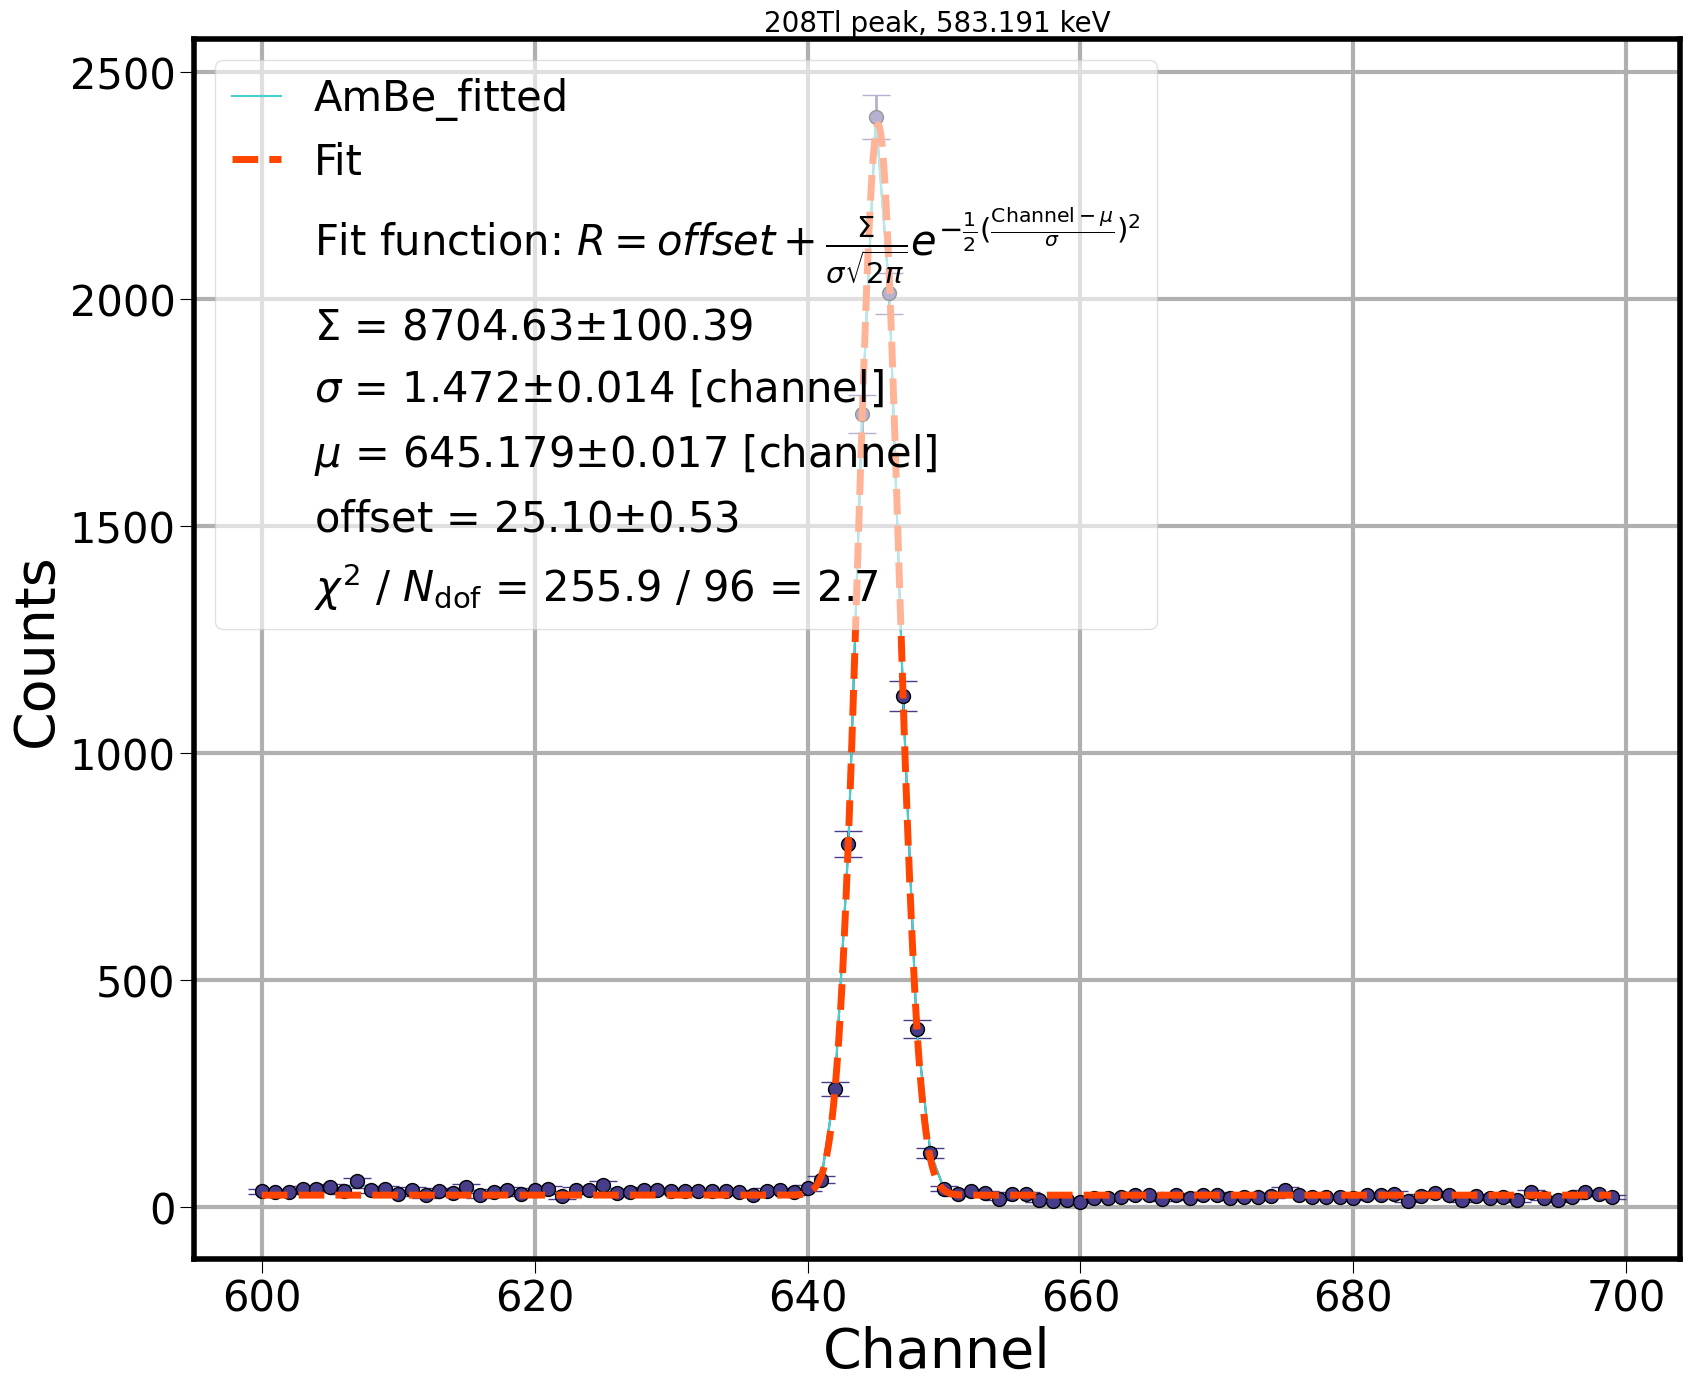

In [11]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()






ch1=600
ch2=700
ch3=600
ch4=700

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 645
sig00 = 5 
offset00 = 100

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 727.33 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.73 (χ²/ndof = 1.4)      │              Nfcn = 105              │
│ EDM = 7.92e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.64e3   │  0.04e3   │            │            │         │         │       │
│ 1 │ sig    │   1.533   │   0.034   │            │            │         │         │       │
│ 2 │ mu     │  804.42   │   0.04    │            │            │         │         │       │
│ 3 │ offset │   14.2    │    0.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │ 1.8e+03  0.1666 -0.0011   -3.23 │
│    sig │  0.1666 0.00118 -0.0001 -0.0033 │
│     mu │ -0.0011 -0.0001 0.00173  0.0000 │
│ offset │   -3.23 -0.0033  0.0000   0.349 │
└────────┴─────────────────────────────────┘

<ValueView A=1641.7975451141667 sig=1.5333437335293818 mu=804.421410582899 offset=14.213904030735852>
<ErrorView A=42.466473875379464 sig=0.03440213622405716 mu=0.04154623780357004 offset=0.5906642371641837>
(1641.7975451141667, 1.5333437335293818, 804.421410582899, 14.213904030735852)


/tmp/ipykernel_23199/1427234190.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24358253c0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1427234190.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1427234190.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24358253c0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

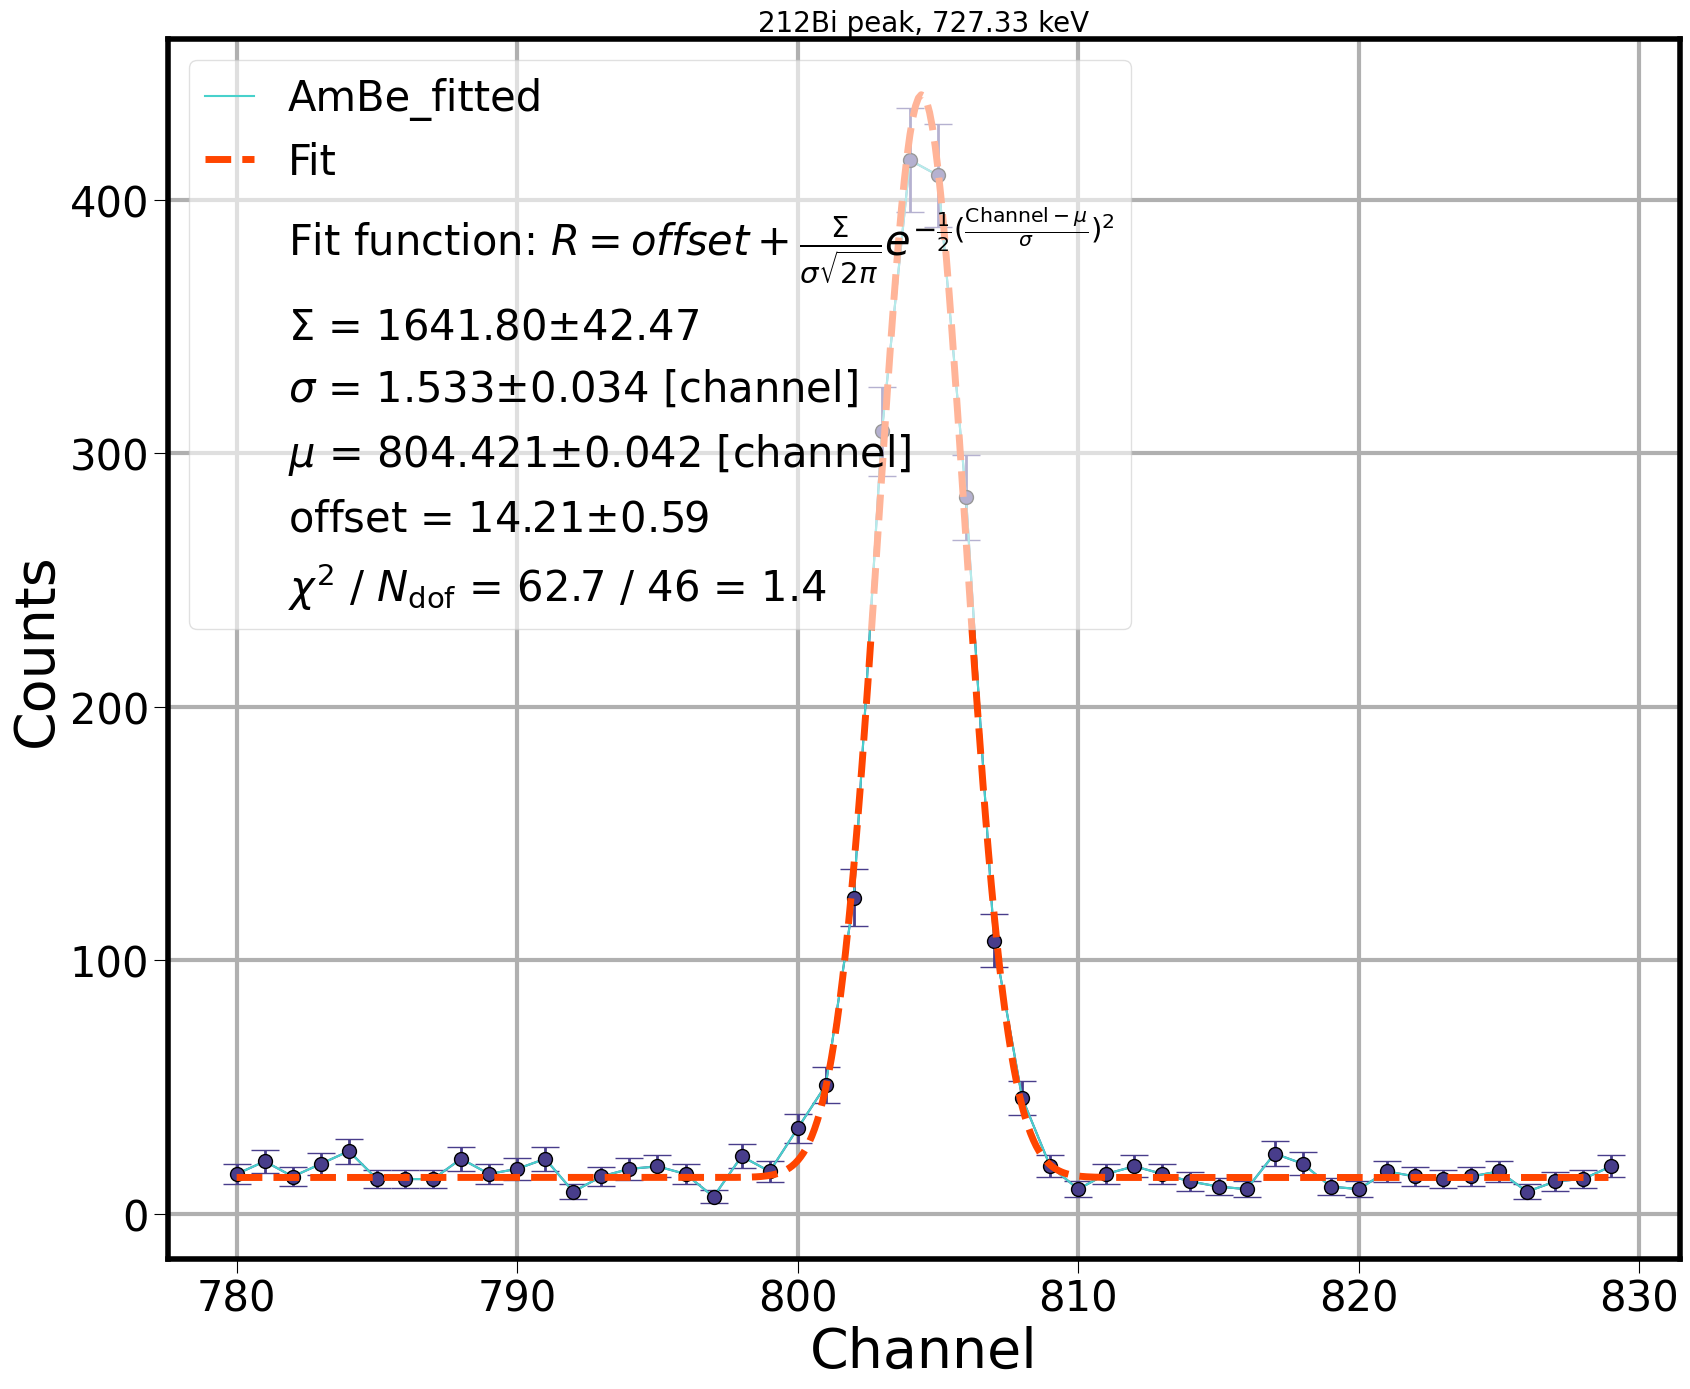

In [12]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()





ch1=780
ch2=830
ch3=780
ch4=830

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 805
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 763.13 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.01 (χ²/ndof = 0.9)      │              Nfcn = 83               │
│ EDM = 2.2e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    173    │    18     │            │            │         │         │       │
│ 1 │ sig    │   1.68    │   0.17    │            │            │         │         │       │
│ 2 │ mu     │  843.93   │   0.19    │            │            │         │         │       │
│ 3 │ offset │   10.5    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    319  1.125  0.183   -4.8 │
│    sig │  1.125 0.0281  0.006 -0.038 │
│     mu │  0.183  0.006 0.0349 -0.006 │
│ offset │   -4.8 -0.038 -0.006  0.512 │
└────────┴─────────────────────────────┘

<ValueView A=173.43333689136705 sig=1.6806369291801484 mu=843.9253303346469 offset=10.512641879706129>
<ErrorView A=17.851114467513042 sig=0.16751510134916542 mu=0.18669179345325362 offset=0.7153927195846486>
(173.43333689136705, 1.6806369291801484, 843.9253303346469, 10.512641879706129)


/tmp/ipykernel_23199/680140255.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f243424a3e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/680140255.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/680140255.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f243424a3e0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

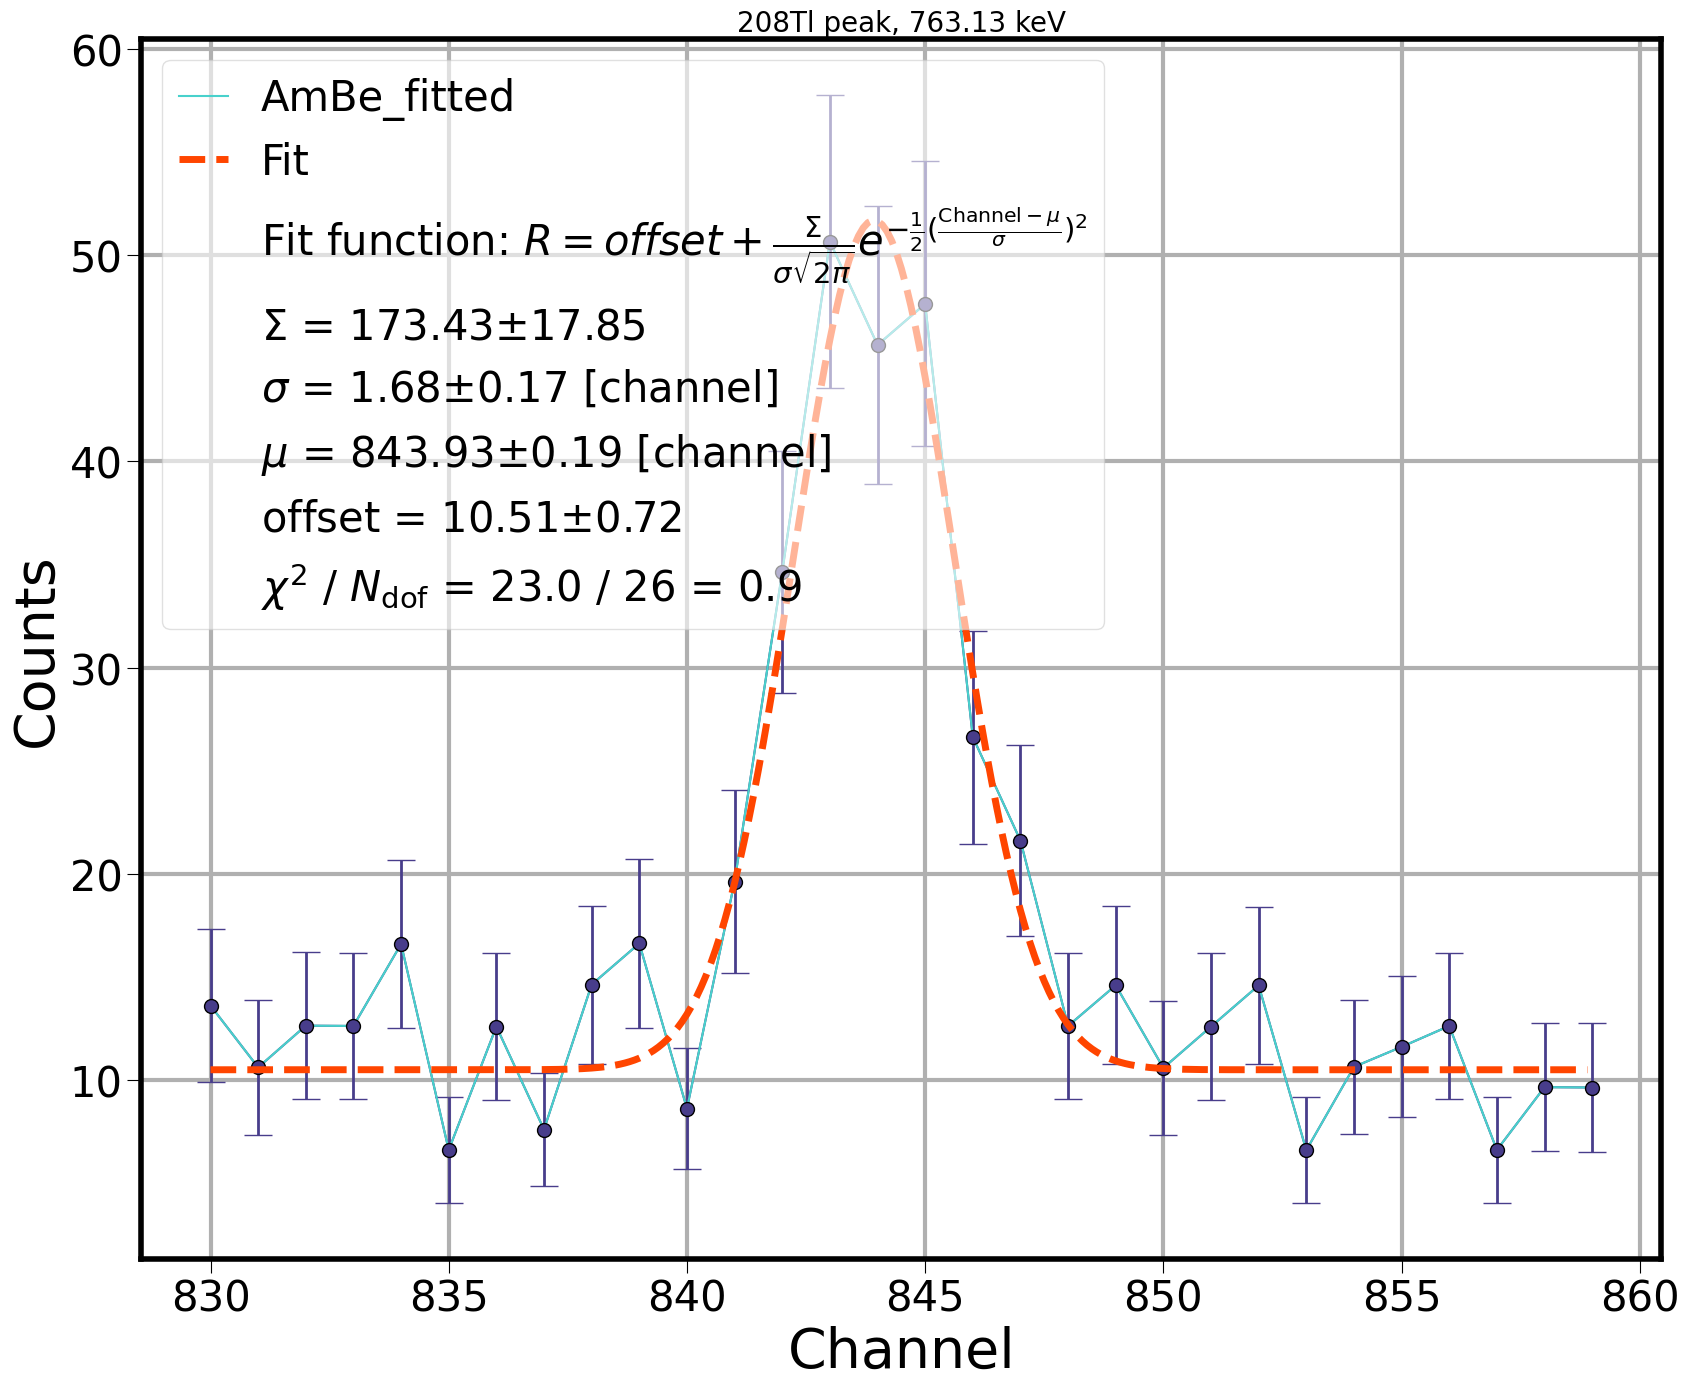

In [13]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()



ch1=830
ch2=860
ch3=830
ch4=860

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 200
mu00 = 844
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    #full legend
    #leg = plt.legend(handles=[(Data_w_sputter_err,Data_w_sputter), Fit_w_sputter, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra, extra], 
     #                labels = [Data_w_sputter.get_label(), Fit_w_sputter.get_label(), text10, text11, text111, text112, text12, text121, text122, text13, text131, text132, text14, text141,text_chi_1],
      #               prop={'size': 20}, loc = 'upper left', fancybox=True, framealpha=0.6)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 785.37 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.79 (χ²/ndof = 0.9)      │              Nfcn = 213              │
│ EDM = 1.47e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    264    │    20     │            │            │         │         │       │
│ 1 │ sig    │   1.45    │   0.12    │            │            │         │         │       │
│ 2 │ mu     │  869.06   │   0.12    │            │            │         │         │       │
│ 3 │ offset │   10.0    │    0.9    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    412  0.867  0.237   -7.4 │
│    sig │  0.867 0.0153  0.005 -0.043 │
│     mu │  0.237  0.005 0.0147 -0.012 │
│ offset │   -7.4 -0.043 -0.012  0.872 │
└────────┴─────────────────────────────┘

<ValueView A=263.82320756610414 sig=1.4530414128163132 mu=869.0617429626594 offset=10.011357591409224>
<ErrorView A=20.302593348153298 sig=0.12356431097813034 mu=0.12140153145893265 offset=0.9335490557337534>
(263.82320756610414, 1.4530414128163132, 869.0617429626594, 10.011357591409224)


/tmp/ipykernel_23199/3973849211.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2435a13340> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/3973849211.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/3973849211.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2435a13340> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

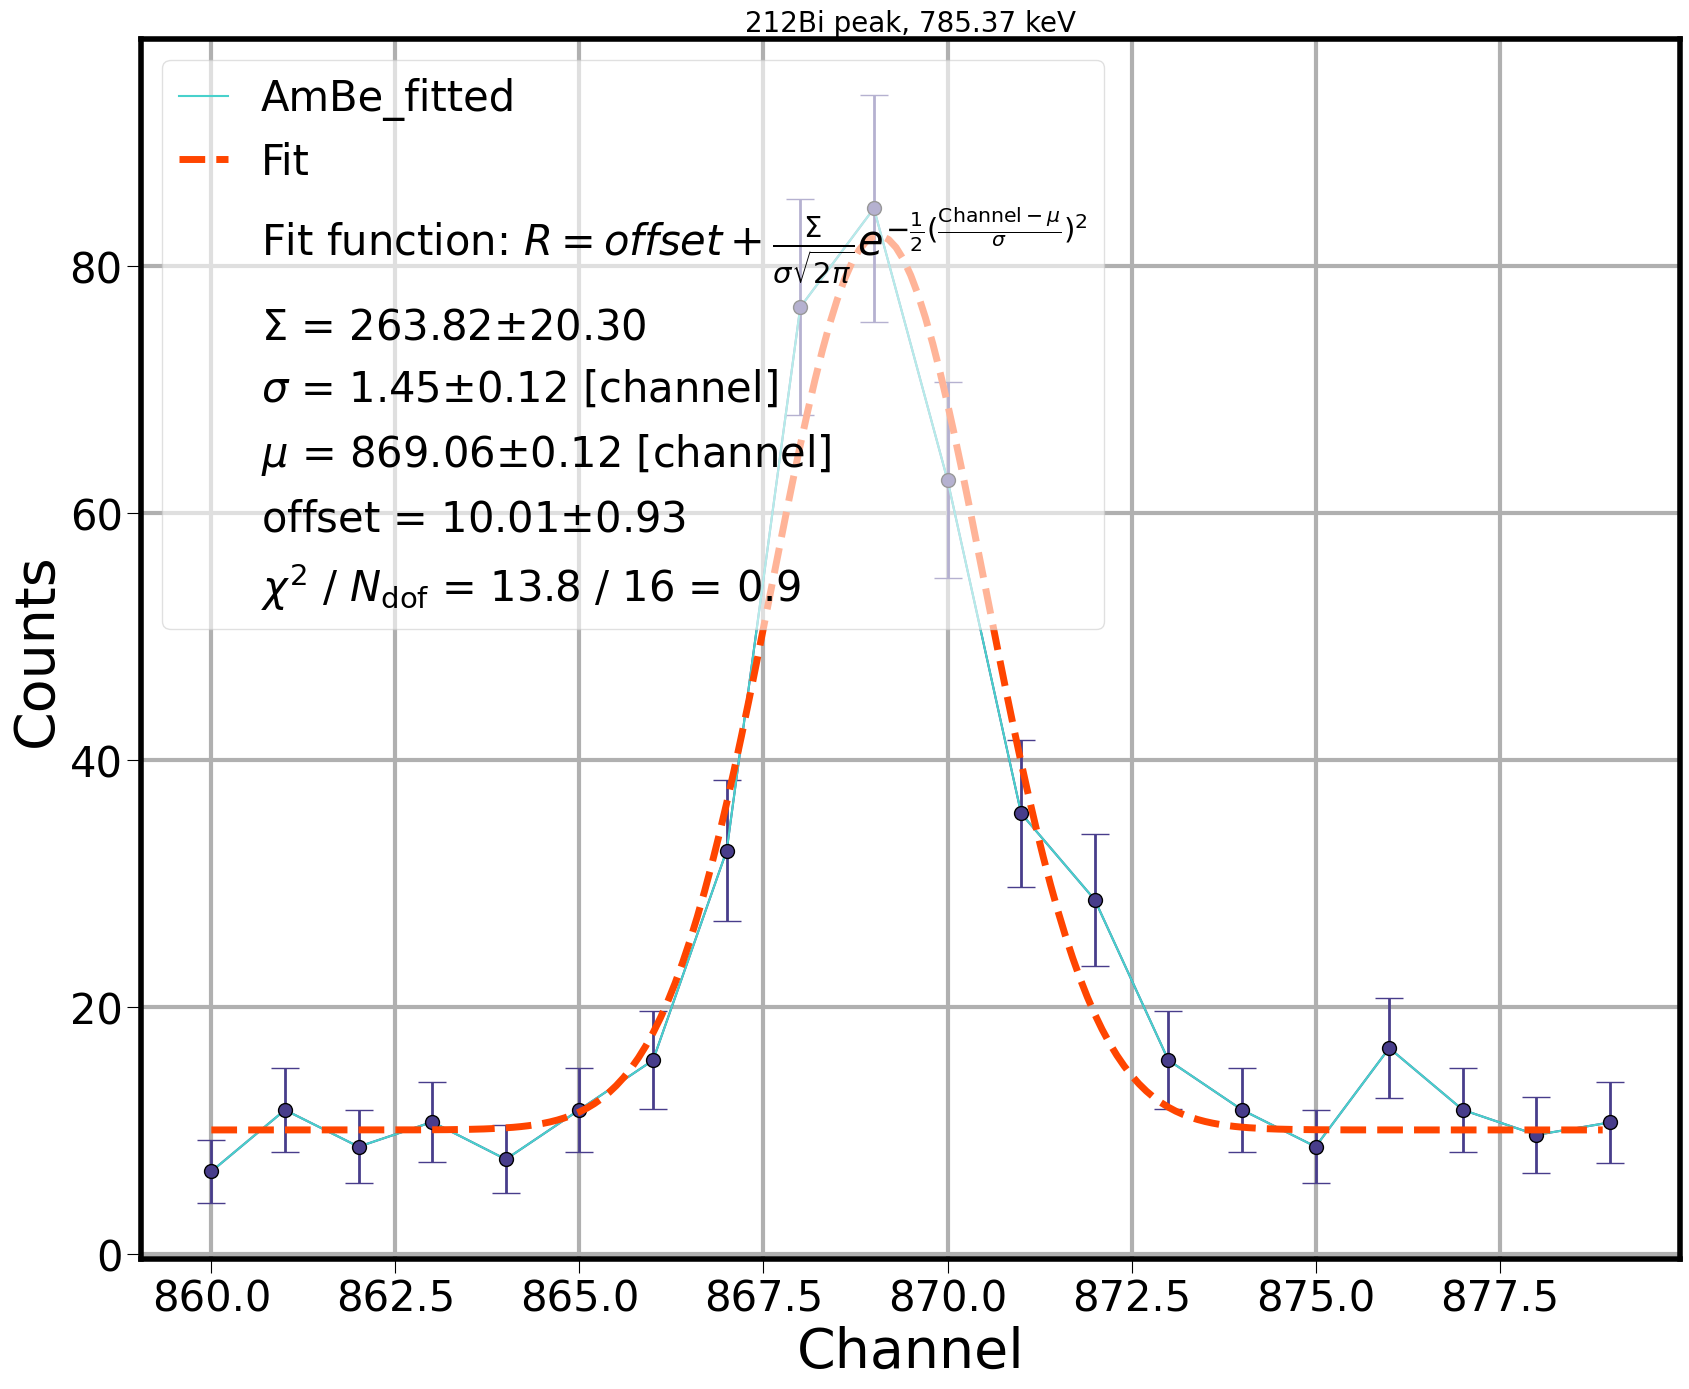

In [14]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()




ch1=860
ch2=880
ch3=860
ch4=880

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 867
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 860.564 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 56.2 (χ²/ndof = 1.6)       │              Nfcn = 139              │
│ EDM = 2.11e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  1.032e3  │  0.034e3  │            │            │         │         │       │
│ 1 │ sig    │   1.53    │   0.04    │            │            │         │         │       │
│ 2 │ mu     │  951.64   │   0.05    │            │            │         │         │       │
│ 3 │ offset │    8.6    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 1.14e+03   0.1729  -0.0030    -2.67 │
│    sig │   0.1729  0.00177  -0.0000  -0.0043 │
│     mu │  -0.0030  -0.0000  0.00275   0.0001 │
│ offset │    -2.67  -0.0043   0.0001    0.282 │
└────────┴─────────────────────────────────────┘

<ValueView A=1031.865455493925 sig=1.5310325077896434 mu=951.6381085626026 offset=8.621803667488093>
<ErrorView A=33.74508195240259 sig=0.04202093601907004 mu=0.052410352145444705 offset=0.5313601581493786>
(1031.865455493925, 1.5310325077896434, 951.6381085626026, 8.621803667488093)


/tmp/ipykernel_23199/4157484480.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24361e0310> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/4157484480.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/4157484480.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24361e0310> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

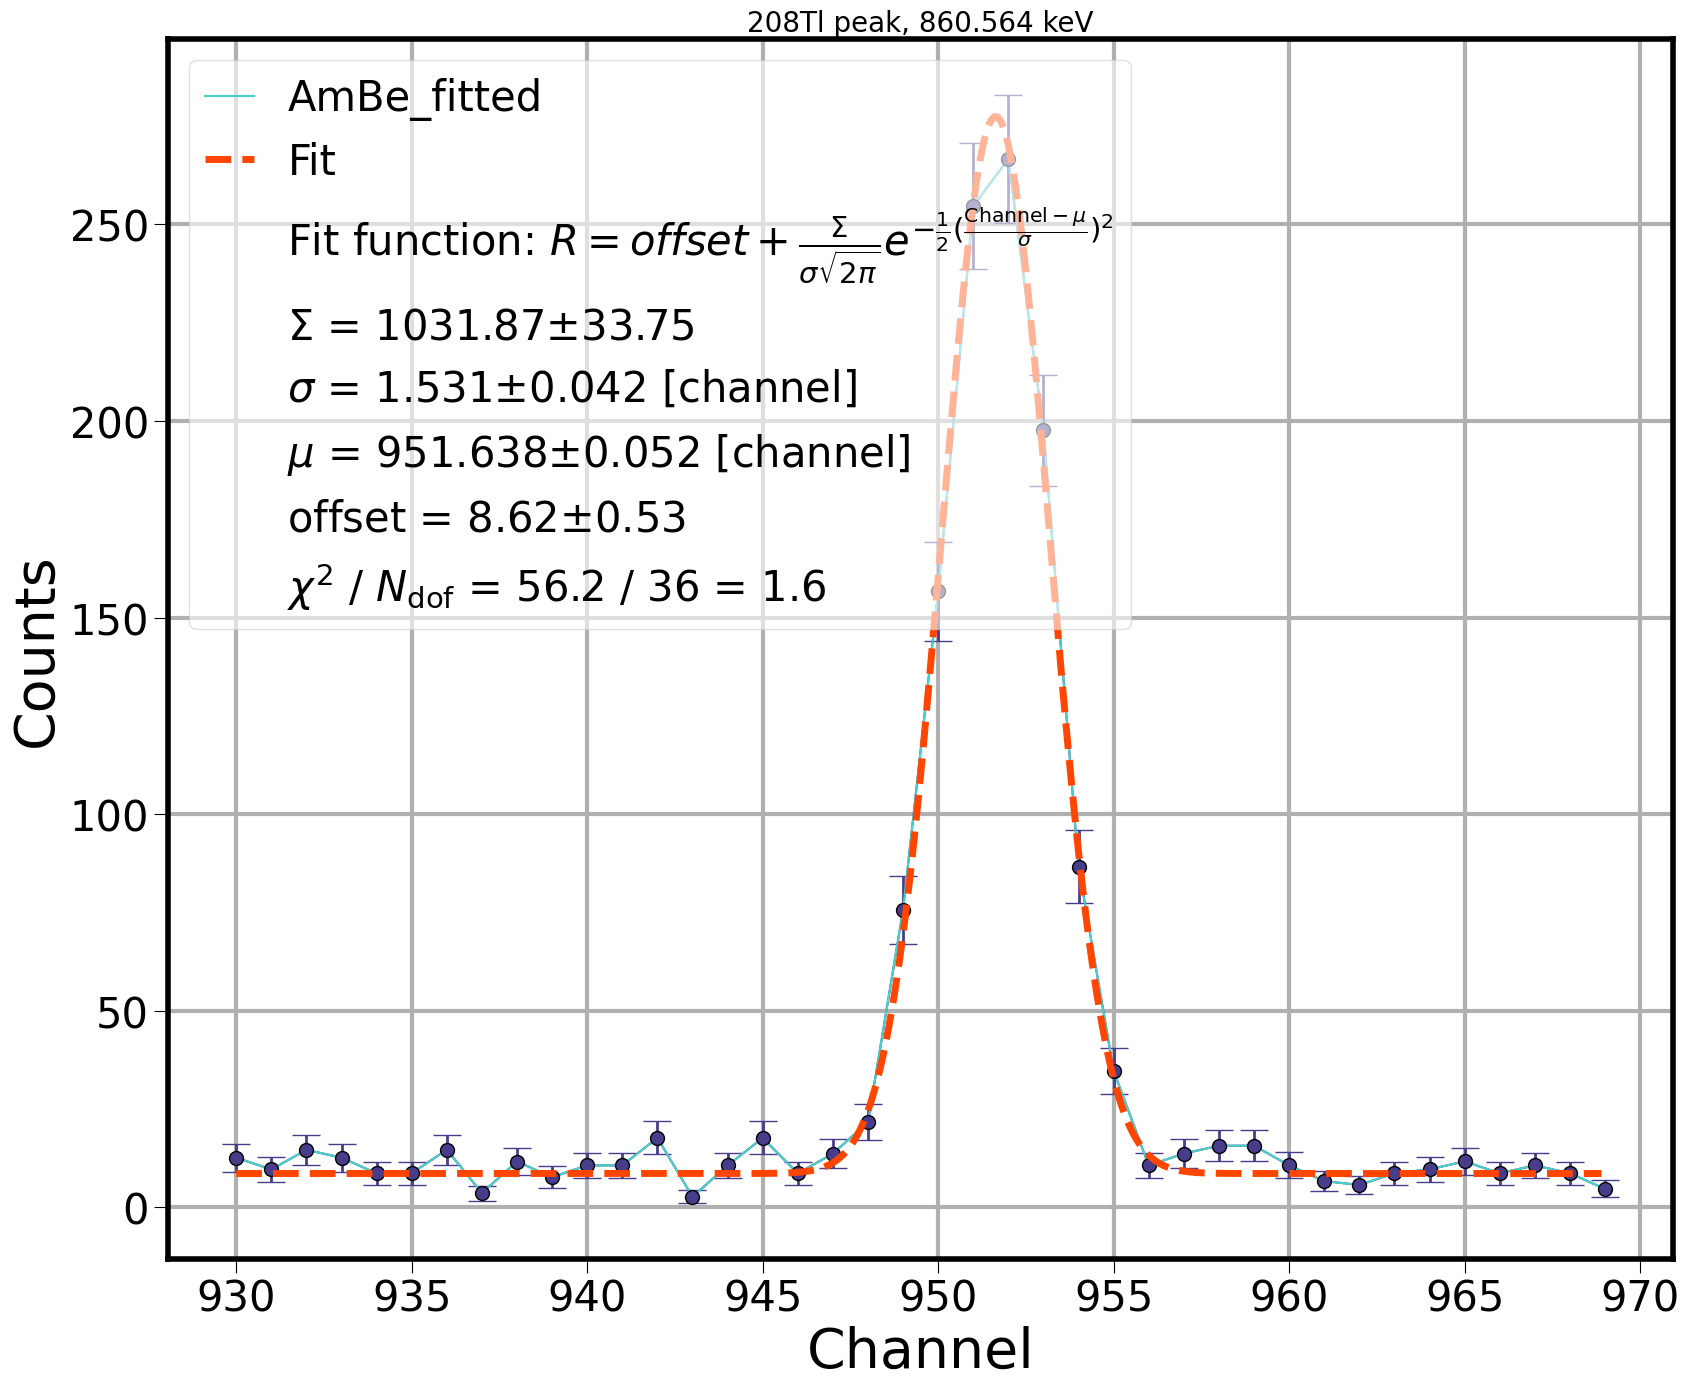

In [15]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=930
ch2=970
ch3=930
ch4=970

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 950
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 893.408 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.63 (χ²/ndof = 0.9)      │              Nfcn = 215              │
│ EDM = 6.71e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    71     │    14     │            │            │         │         │       │
│ 1 │ sig    │    1.8    │    0.4    │            │            │         │         │       │
│ 2 │ mu     │  988.12   │   0.35    │            │            │         │         │       │
│ 3 │ offset │    7.5    │    0.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    186   2.44  -0.23   -3.8 │
│    sig │   2.44  0.136  -0.02  -0.08 │
│     mu │  -0.23  -0.02   0.12   0.01 │
│ offset │   -3.8  -0.08   0.01  0.378 │
└────────┴─────────────────────────────┘

<ValueView A=71.34335669971178 sig=1.7791119389060612 mu=988.1244881730862 offset=7.49838269687593>
<ErrorView A=13.651343798916848 sig=0.36895459689984694 mu=0.34630959843141745 offset=0.6146385233560158>
(71.34335669971178, 1.7791119389060612, 988.1244881730862, 7.49838269687593)


/tmp/ipykernel_23199/140013519.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f243431feb0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/140013519.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/140013519.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f243431feb0> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

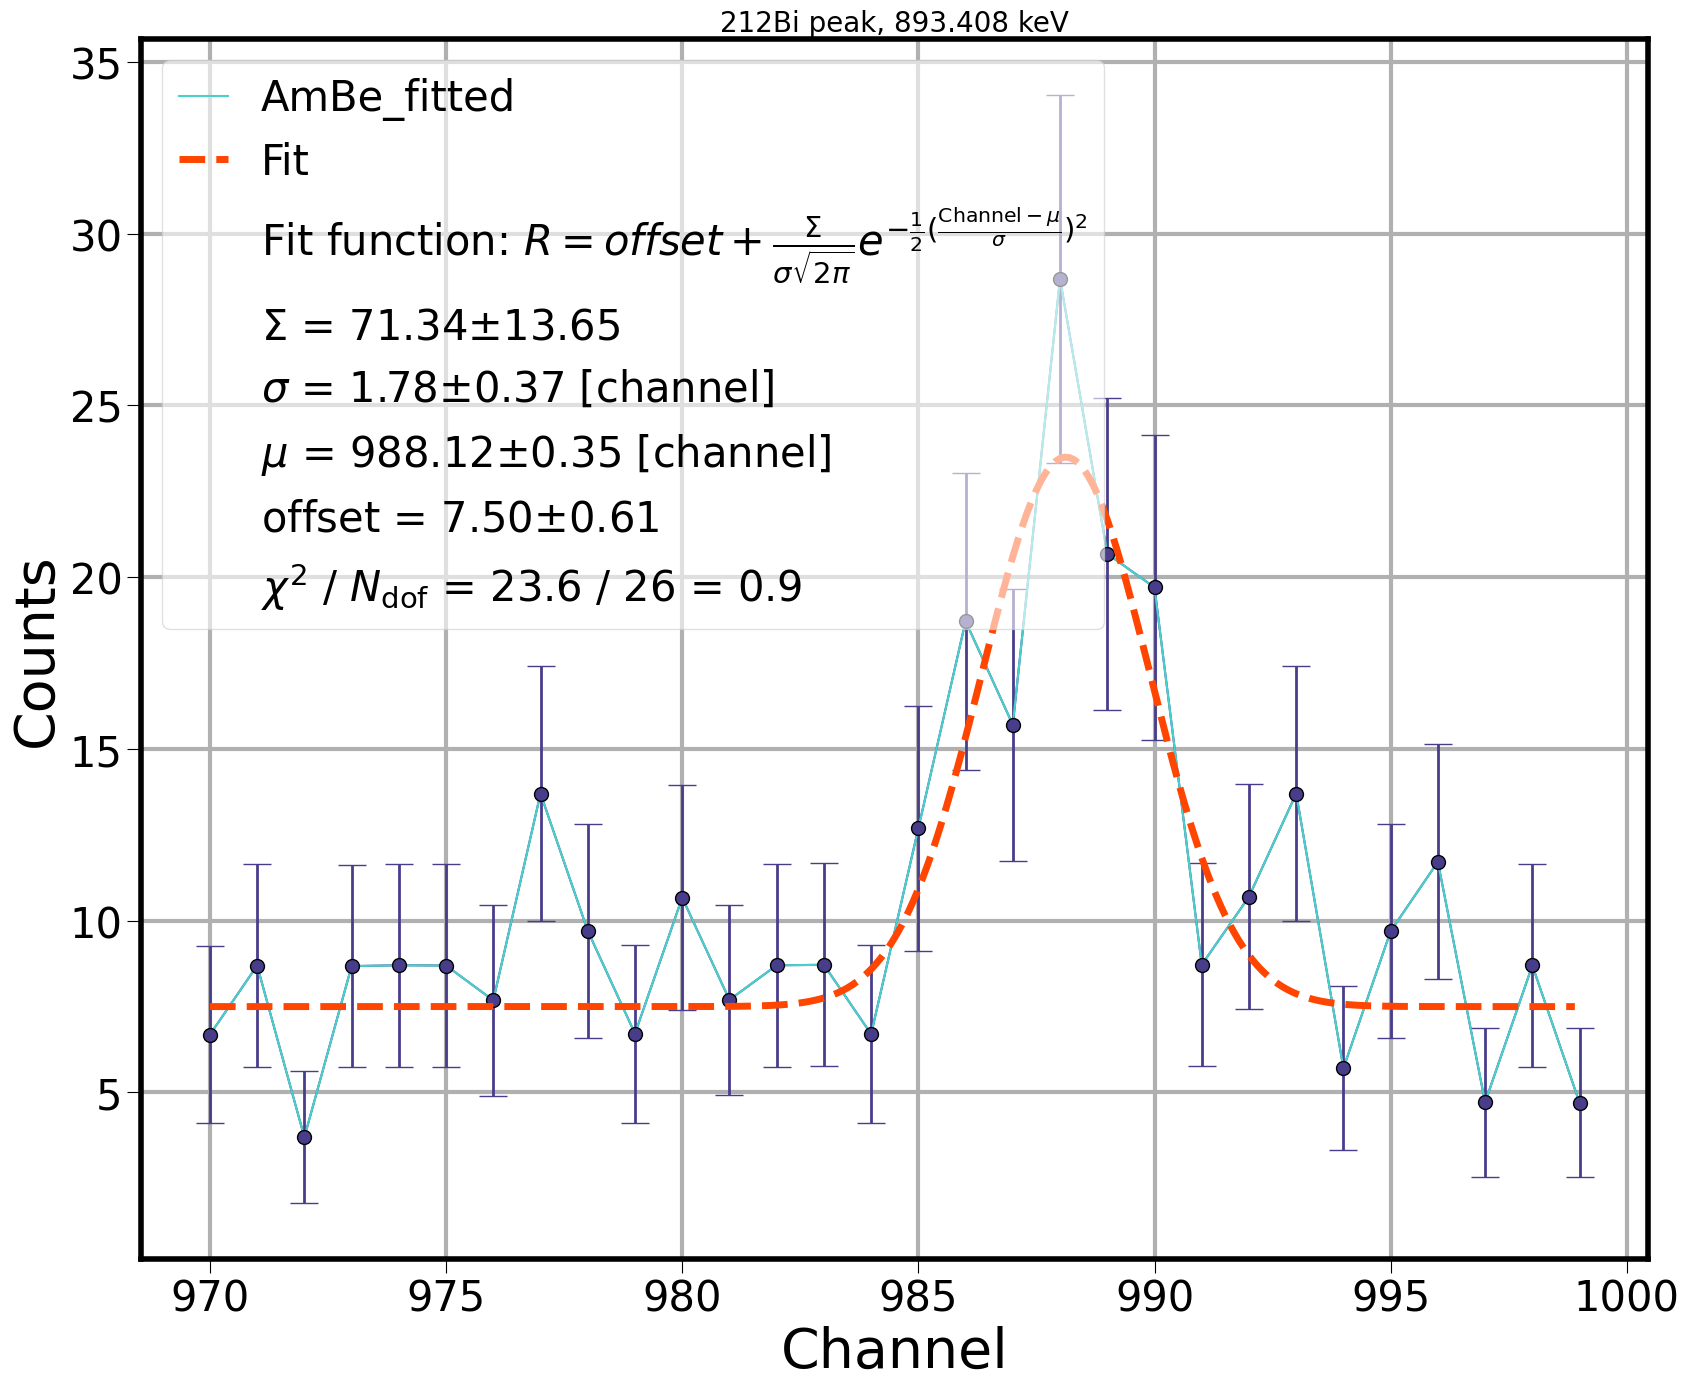

In [16]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=970
ch2=1000
ch3=970
ch4=1000

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 990
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1078.62 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.7 (χ²/ndof = 0.6)       │              Nfcn = 140              │
│ EDM = 1.82e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    122    │    15     │            │            │         │         │       │
│ 1 │ sig    │   1.76    │   0.21    │            │            │         │         │       │
│ 2 │ mu     │ 1.19288e3 │ 0.00022e3 │            │            │         │         │       │
│ 3 │ offset │    6.2    │    0.6    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    220   1.17   0.06   -4.0 │
│    sig │   1.17 0.0441   0.01  -0.05 │
│     mu │   0.06   0.01 0.0503  -0.00 │
│ offset │   -4.0  -0.05  -0.00  0.406 │
└────────┴─────────────────────────────┘

<ValueView A=121.62394184219514 sig=1.755143320122609 mu=1192.8807033957062 offset=6.150430512025946>
<ErrorView A=14.833070973240892 sig=0.21000308945718926 mu=0.2241813667114995 offset=0.6372501686674437>
(121.62394184219514, 1.755143320122609, 1192.8807033957062, 6.150430512025946)


/tmp/ipykernel_23199/1152623272.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2435824910> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1152623272.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1152623272.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2435824910> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

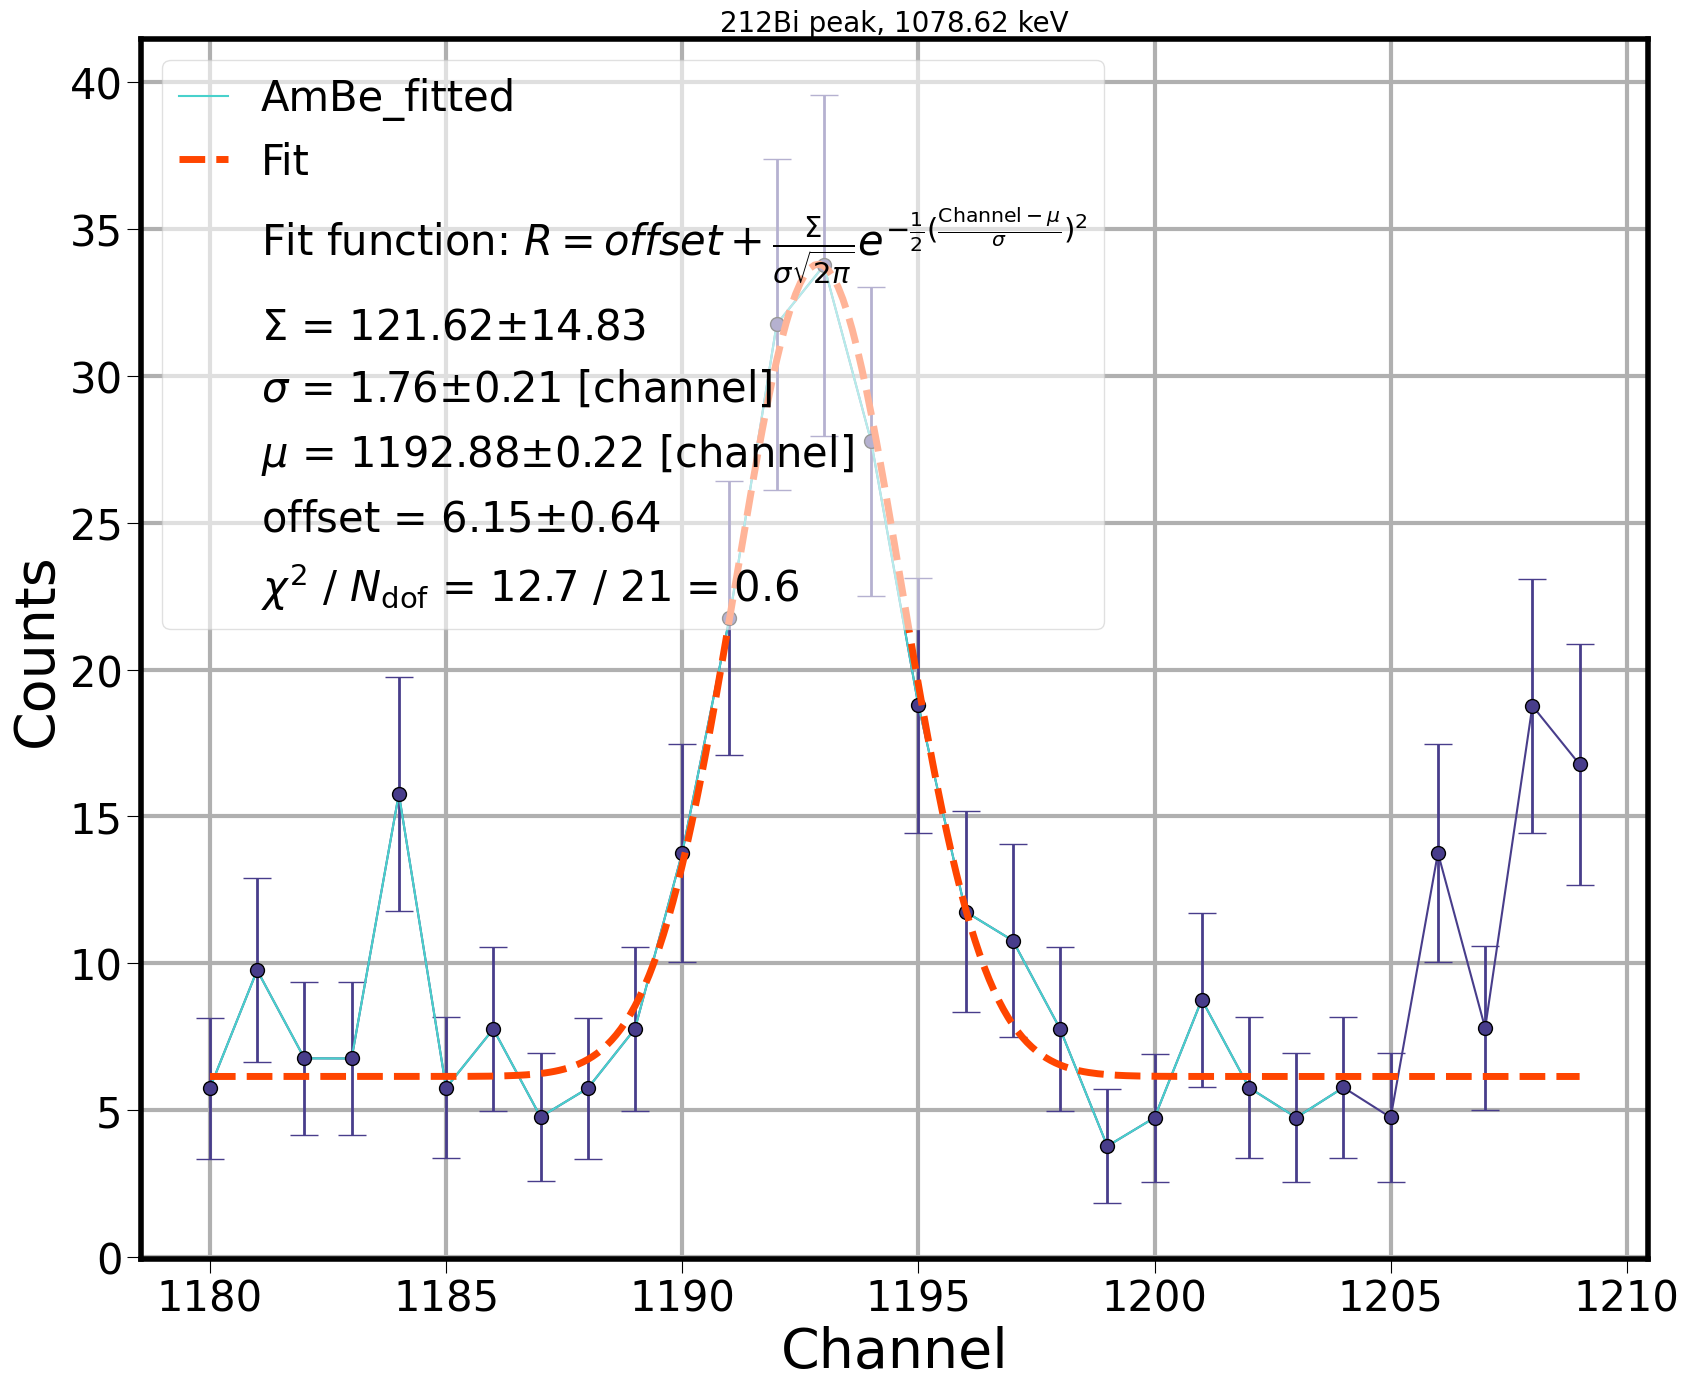

In [17]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1180
ch2=1205
ch3=1180
ch4=1210

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1200
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)


#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1093.9 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.71 (χ²/ndof = 1.0)      │              Nfcn = 262              │
│ EDM = 7.95e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    51     │    11     │            │            │         │         │       │
│ 1 │ sig    │    1.5    │    0.4    │            │            │         │         │       │
│ 2 │ mu     │ 1.20890e3 │ 0.00033e3 │            │            │         │         │       │
│ 3 │ offset │    4.7    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    114   1.99  -0.34  -2.09 │
│    sig │   1.99   0.16  -0.03  -0.07 │
│     mu │  -0.34  -0.03  0.108   0.01 │
│ offset │  -2.09  -0.07   0.01  0.226 │
└────────┴─────────────────────────────┘

<ValueView A=51.28489204744039 sig=1.518641165709324 mu=1208.9028860850767 offset=4.701061373644312>
<ErrorView A=10.671185334675352 sig=0.399586447287018 mu=0.32814110672556807 offset=0.4756691015228514>
(51.28489204744039, 1.518641165709324, 1208.9028860850767, 4.701061373644312)


/tmp/ipykernel_23199/2507441902.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2434447580> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/2507441902.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/2507441902.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2434447580> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

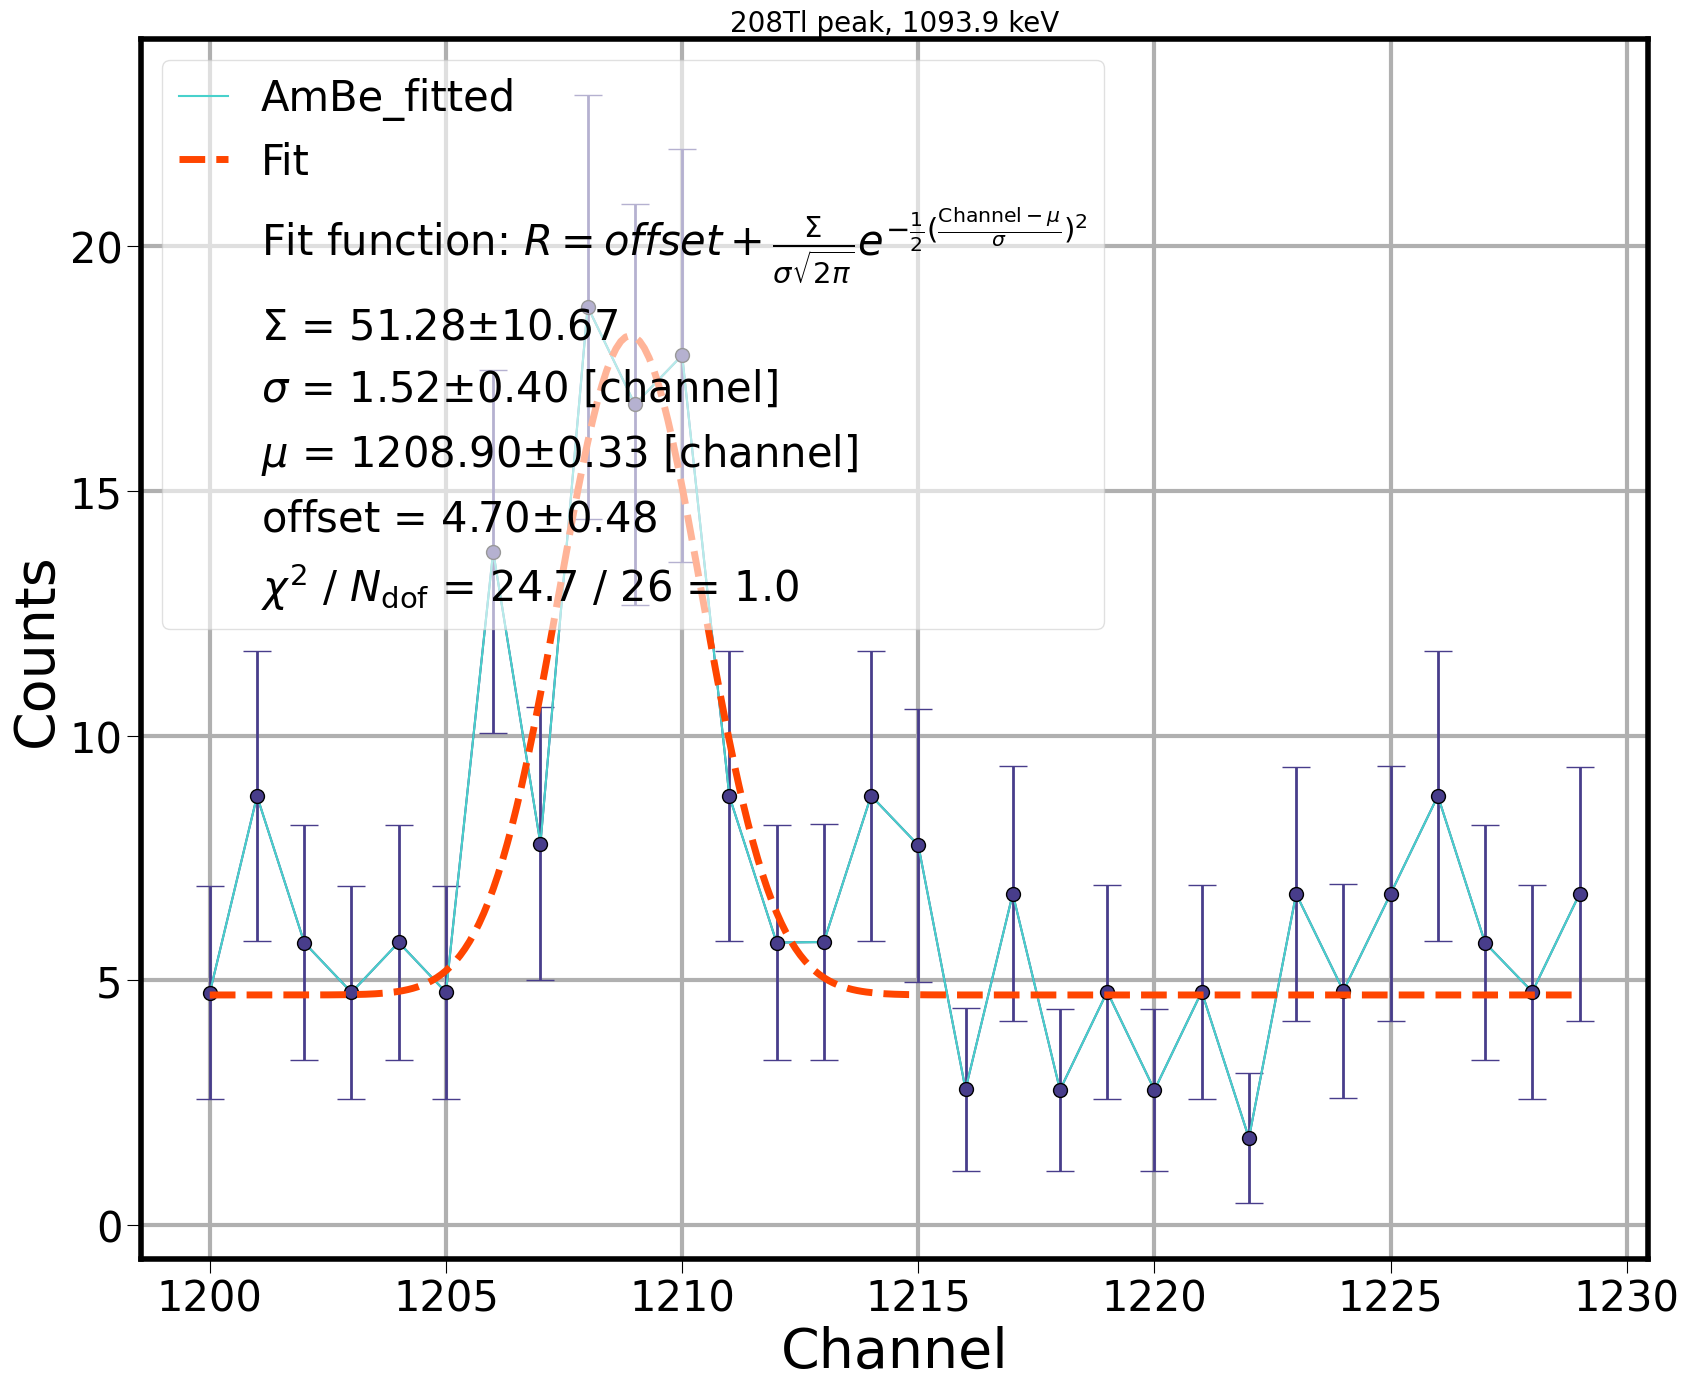

In [18]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1200
ch2=1230
ch3=1200
ch4=1230

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1210
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1512.7 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 52.48 (χ²/ndof = 1.1)      │              Nfcn = 325              │
│ EDM = 3.96e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    60     │    10     │            │            │         │         │       │
│ 1 │ sig    │   1.38    │   0.22    │            │            │         │         │       │
│ 2 │ mu     │ 1.61388e3 │ 0.00025e3 │            │            │         │         │       │
│ 3 │ offset │   4.14    │   0.31    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │   97.5   0.69  -0.00  -0.75 │
│    sig │   0.69 0.0502   0.00  -0.01 │
│     mu │  -0.00   0.00 0.0618   0.00 │
│ offset │  -0.75  -0.01   0.00 0.0978 │
└────────┴─────────────────────────────┘

<ValueView A=60.025086450880195 sig=1.3765749761641777 mu=1613.880237563649 offset=4.140094383081633>
<ErrorView A=9.874800509358826 sig=0.2240499565795964 mu=0.2486760438364379 offset=0.3127166445979883>
(60.025086450880195, 1.3765749761641777, 1613.880237563649, 4.140094383081633)


/tmp/ipykernel_23199/1597208041.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2435941a20> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/1597208041.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/1597208041.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2435941a20> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

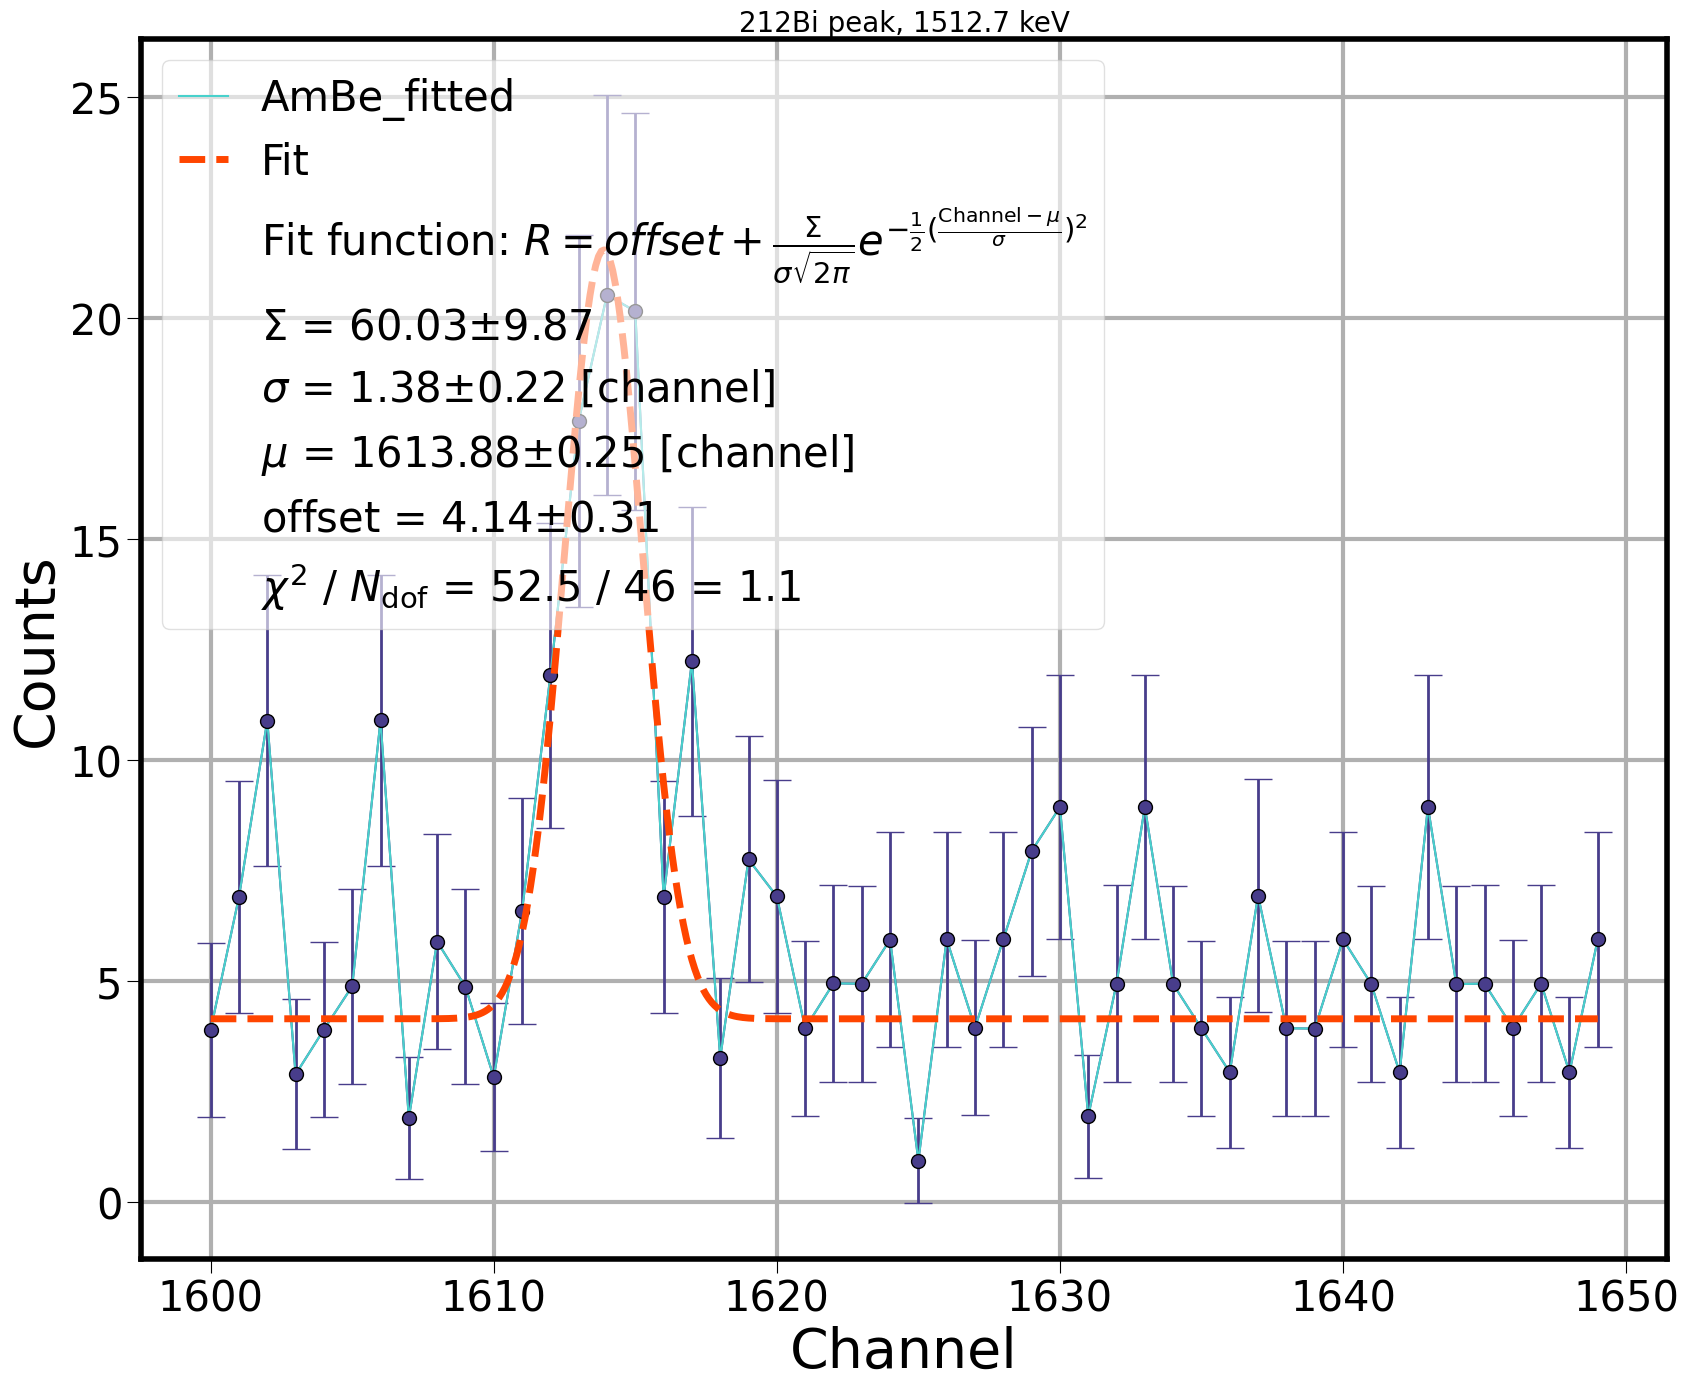

In [19]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1600
ch2=1650
ch3=1600
ch4=1650

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1620
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1592.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.35 (χ²/ndof = 1.2)      │              Nfcn = 134              │
│ EDM = 1.79e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    147    │    15     │            │            │         │         │       │
│ 1 │ sig    │   2.12    │   0.26    │            │            │         │         │       │
│ 2 │ mu     │ 1.75918e3 │ 0.00024e3 │            │            │         │         │       │
│ 3 │ offset │    4.4    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    229   1.34   0.32  -2.04 │
│    sig │   1.34 0.0661   0.02  -0.03 │
│     mu │   0.32   0.02 0.0571  -0.01 │
│ offset │  -2.04  -0.03  -0.01  0.161 │
└────────┴─────────────────────────────┘

<ValueView A=147.19204954307526 sig=2.1214271362351376 mu=1759.18264043847 offset=4.387947909096291>
<ErrorView A=15.12118099460567 sig=0.25701214998681016 mu=0.2390525570469938 offset=0.40079269427525327>
(147.19204954307526, 2.1214271362351376, 1759.18264043847, 4.387947909096291)


/tmp/ipykernel_23199/2702818928.py:215: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24360b7f70> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/2702818928.py:251: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/2702818928.py:258: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f24360b7f70> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

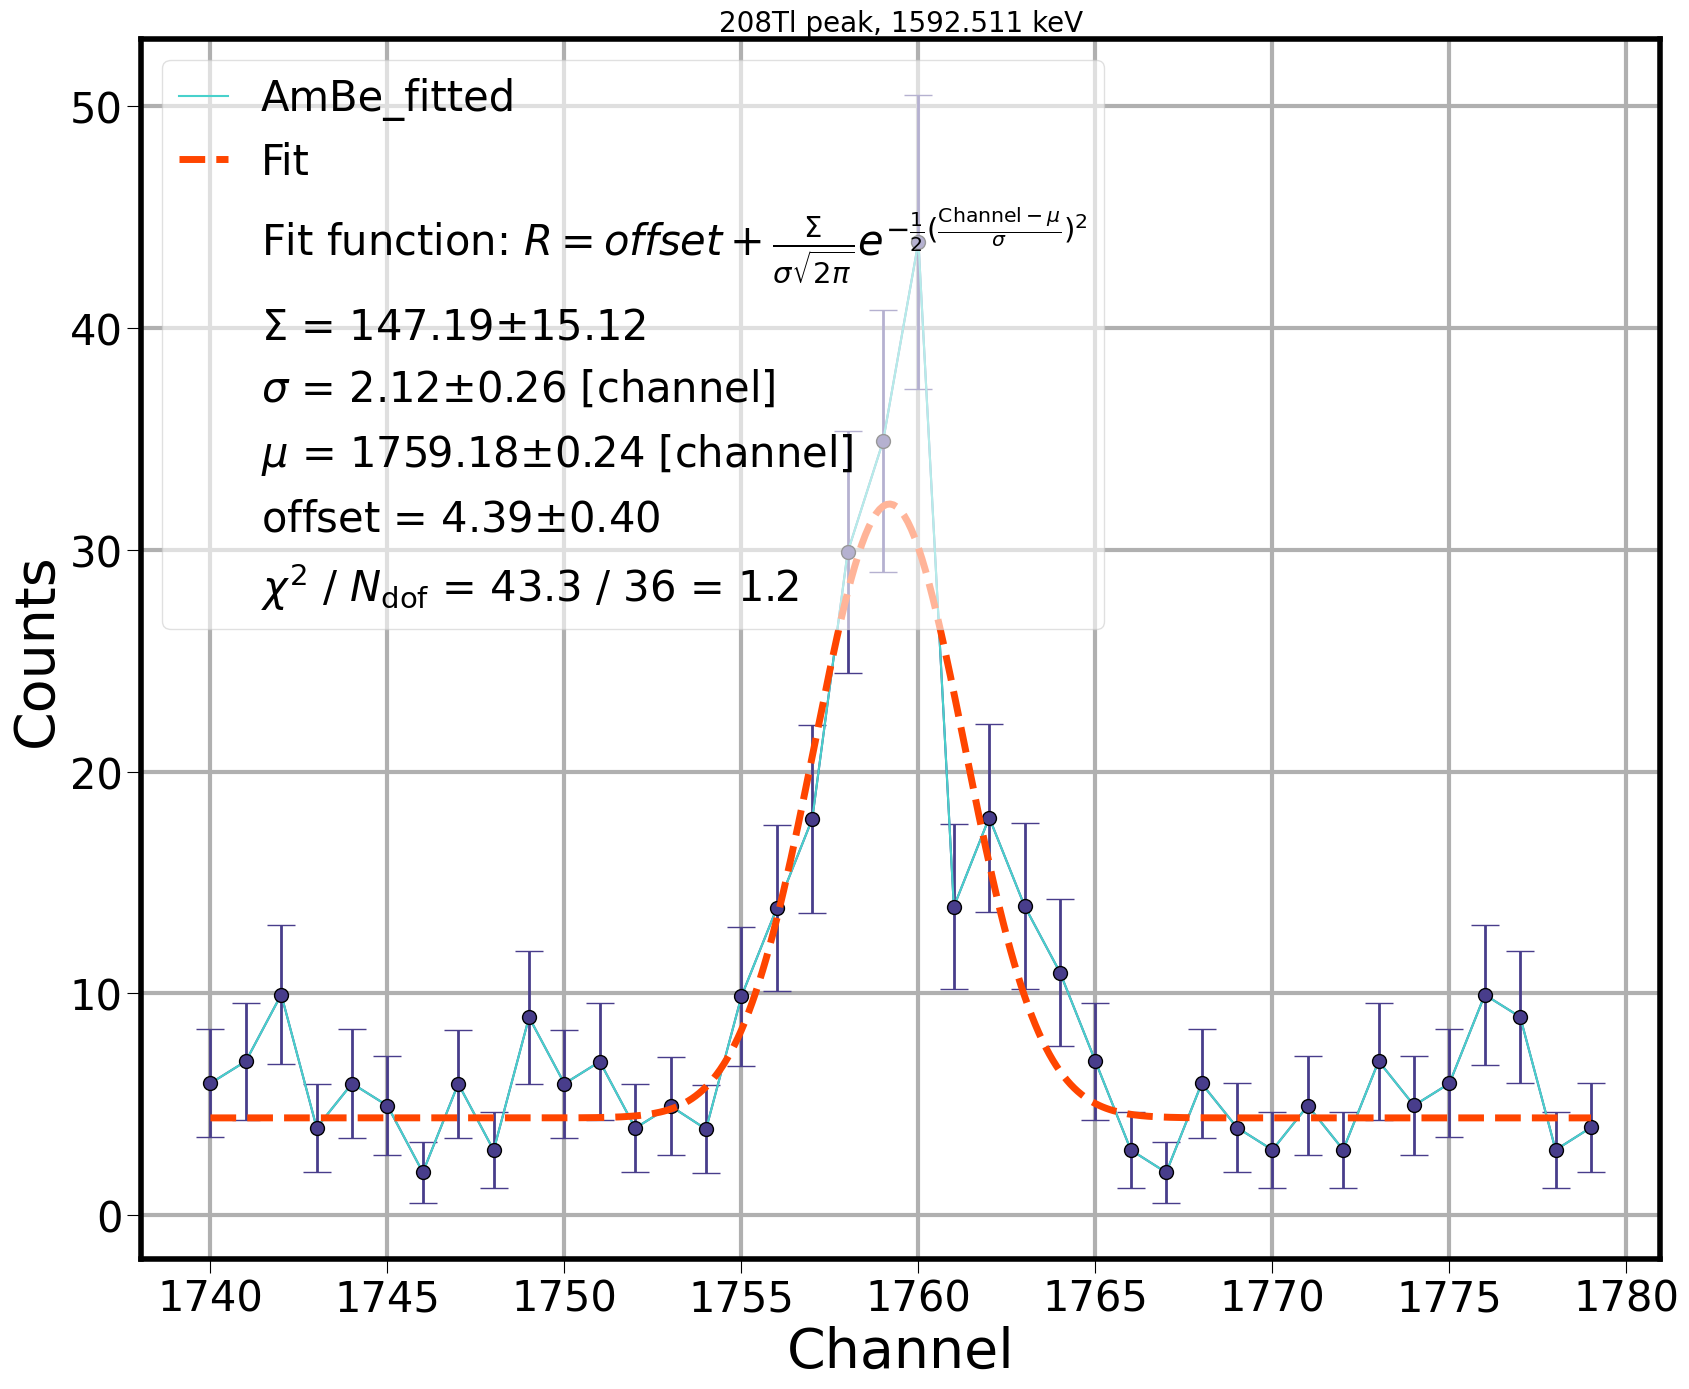

In [20]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()




ch1=1740
ch2=1780
ch3=1740
ch4=1780

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1760
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)


#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1620.5 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 56.61 (χ²/ndof = 2.2)      │              Nfcn = 107              │
│ EDM = 6.56e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    256    │    18     │            │            │         │         │       │
│ 1 │ sig    │   1.90    │   0.12    │            │            │         │         │       │
│ 2 │ mu     │ 1.79104e3 │ 0.00013e3 │            │            │         │         │       │
│ 3 │ offset │    2.9    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    308  0.437 -0.004  -1.74 │
│    sig │  0.437 0.0157  0.001 -0.015 │
│     mu │ -0.004  0.001 0.0179  0.000 │
│ offset │  -1.74 -0.015  0.000  0.156 │
└────────┴─────────────────────────────┘

<ValueView A=256.1597709857311 sig=1.8994138627311365 mu=1791.0362948740842 offset=2.9417501245235353>
<ErrorView A=17.5595828911122 sig=0.1253948337154105 mu=0.1339760601451449 offset=0.3947615207322588>
(256.1597709857311, 1.8994138627311365, 1791.0362948740842, 2.9417501245235353)


/tmp/ipykernel_23199/2411848934.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2436152d40> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/2411848934.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/2411848934.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2436152d40> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

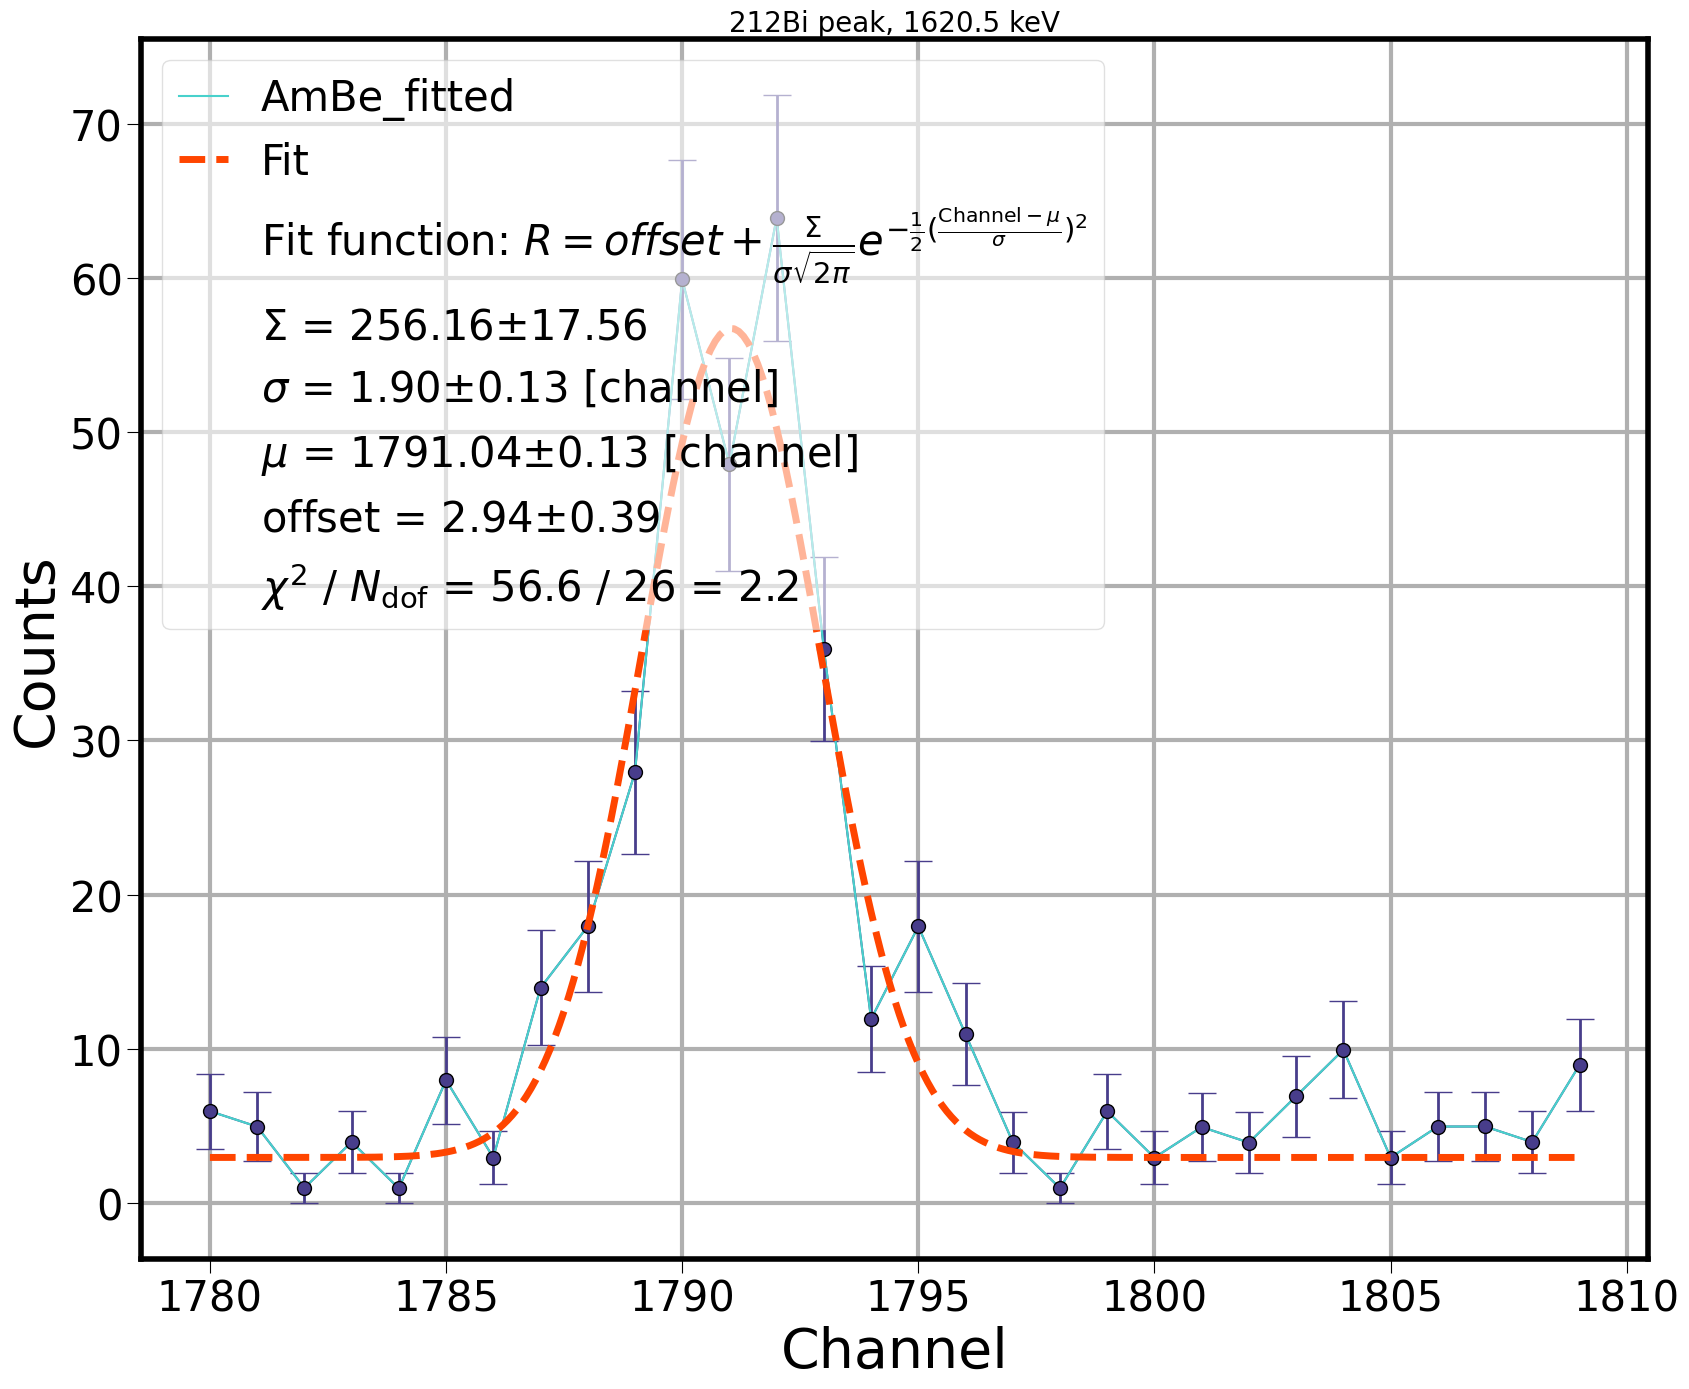

In [21]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()


ch1=1780
ch2=1810
ch3=1780
ch4=1810

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1790
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl SE peak, 2103.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.55 (χ²/ndof = 1.6)      │              Nfcn = 108              │
│ EDM = 1.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    437    │    24     │            │            │         │         │       │
│ 1 │ sig    │   2.53    │   0.16    │            │            │         │         │       │
│ 2 │ mu     │ 2.32425e3 │ 0.00015e3 │            │            │         │         │       │
│ 3 │ offset │    7.6    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────┐
│        │      A    sig     mu offset │
├────────┼─────────────────────────────┤
│      A │    593  0.994  0.043  -3.21 │
│    sig │  0.994 0.0257  0.003 -0.021 │
│     mu │  0.043  0.003 0.0222 -0.002 │
│ offset │  -3.21 -0.021 -0.002  0.217 │
└────────┴─────────────────────────────┘

<ValueView A=437.4682478361002 sig=2.529896926751196 mu=2324.2487465862528 offset=7.589661874251315>
<ErrorView A=24.35452953672797 sig=0.160385148471731 mu=0.14914898459415382 offset=0.4663644780356457>
(437.4682478361002, 2.529896926751196, 2324.2487465862528, 7.589661874251315)


/tmp/ipykernel_23199/3092417758.py:216: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2436347730> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=[Data, Fit, extra, extra],
/tmp/ipykernel_23199/3092417758.py:252: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_23199/3092417758.py:259: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7f2436347730> starts with '_'. It is thus excluded from the legend.
  leg = plt.legend(handles=handlelist,


<Figure size 1700x1400 with 0 Axes>

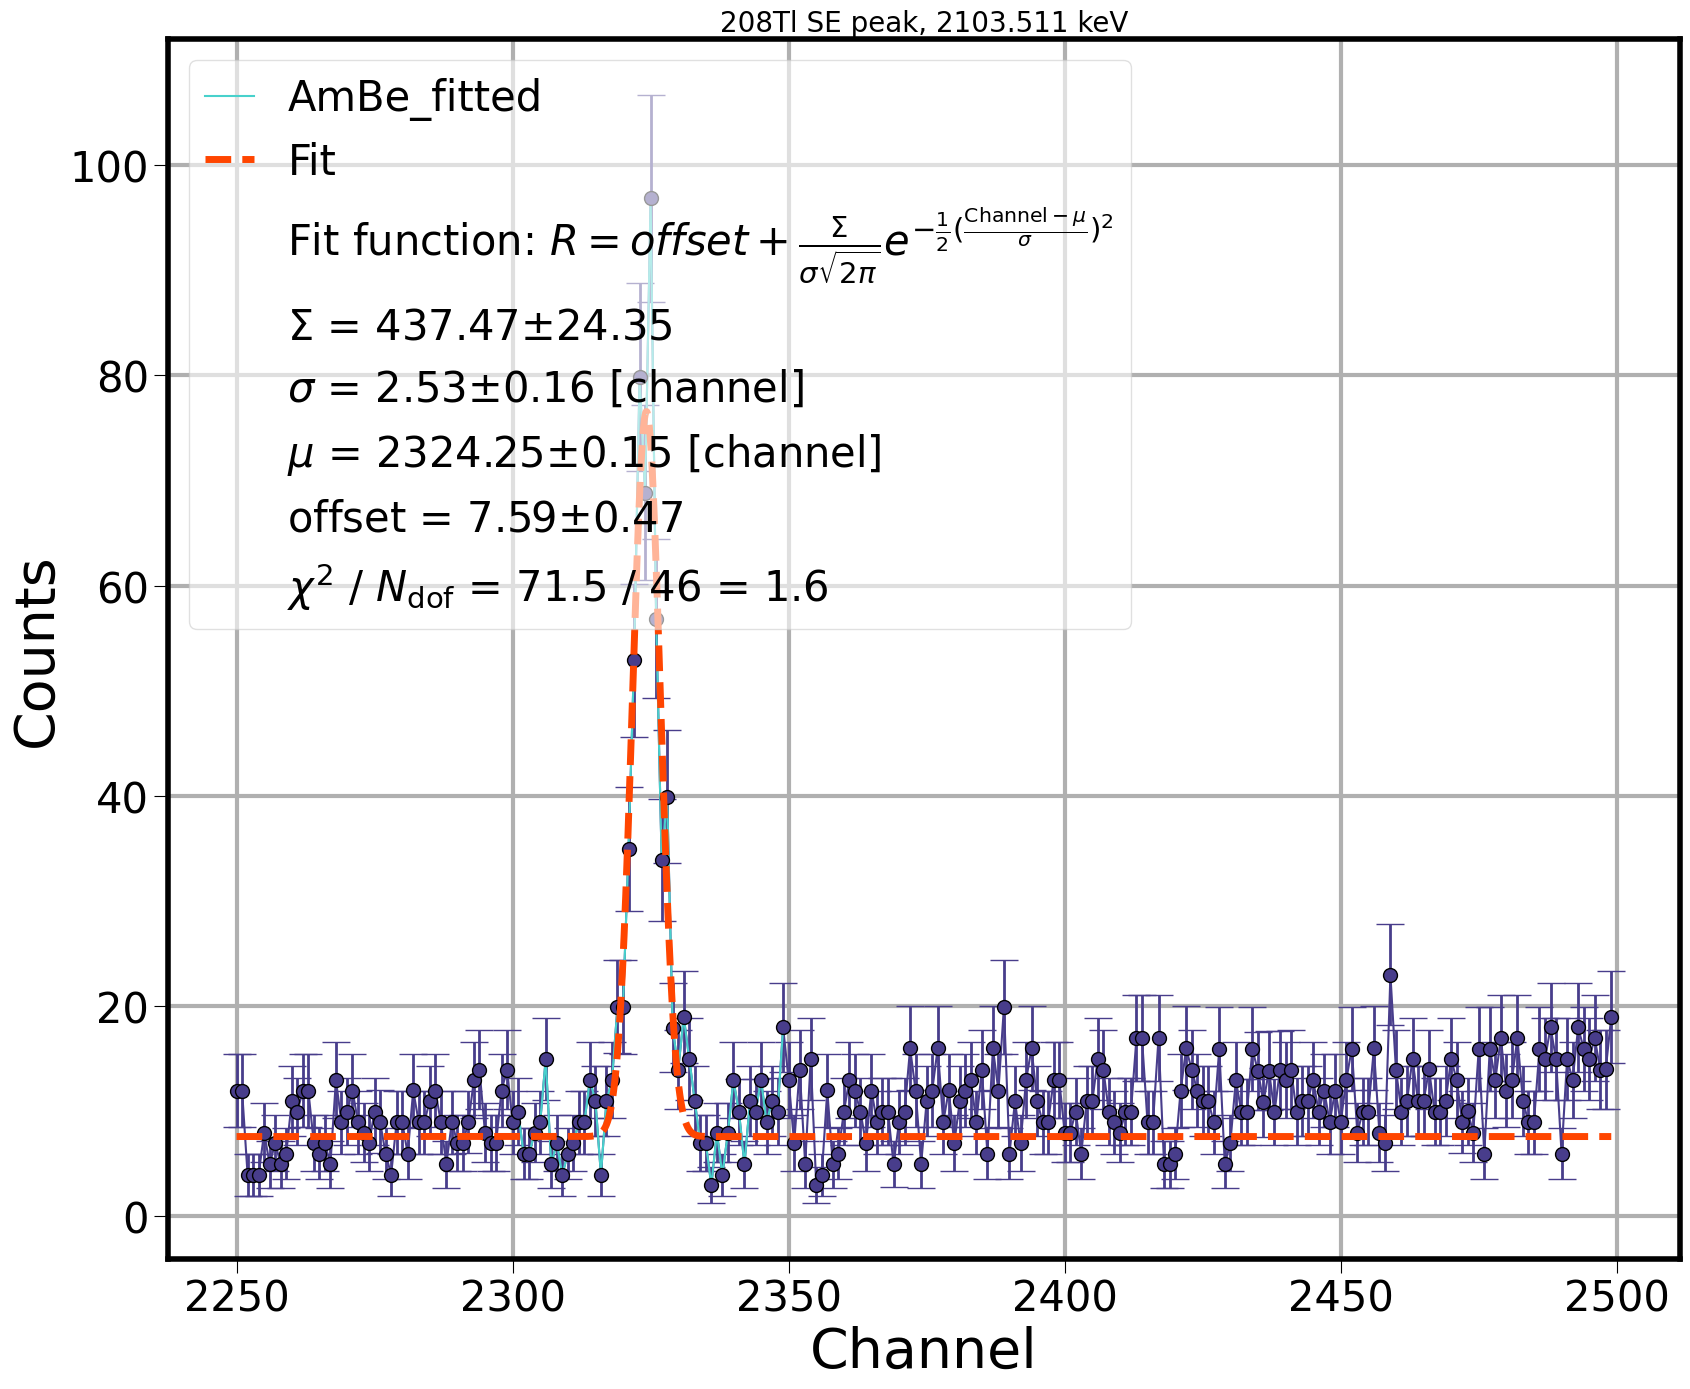

In [22]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()



ch1=2300
ch2=2350
ch3=2250
ch4=2500

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 4000
mu00 = 2325
sig00 = 2 
offset00 = 0

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)

    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


In [23]:
popindex=[13,2]
print(Peak_energy)
for pi in popindex:
    Peak_name.pop(pi)
    Peak_energy.pop(pi) 
    Peak_channel.pop(pi)
    Peak_channel_err.pop(pi)
    Sigma_channel.pop(pi)
    Sigma_channel_err.pop(pi)
    print(Peak_energy)



[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]


'212Bi'

1512.7

1613.880237563649

0.2486760438364379

1.3765749761641777

0.2240499565795964

[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


'212Bi'

288.2

318.63043203290283

0.4280281968798022

1.3002016218856982

0.42011024895100746

[115.183, 277.371, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th energy calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Channel')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 92.57 (χ²/ndof = 7.1)      │              Nfcn = 35               │
│ EDM = 3.98e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   0.97    │   0.04    │            │            │         │         │       │
│ 1 │ p1   │  1.10464  │  0.00006  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        p0        p1 │
├────┼─────────────────────┤
│ p0 │   0.00149 -2.186e-6 │
│ p1 │ -2.186e-6   3.6e-09 │
└────┴─────────────────────┘

<ValueView p0=0.9741066116455137 p1=1.104638330592193>
<ErrorView p0=0.03857331044985906 p1=5.999276033928087e-05>
(0.9741066116455137, 1.104638330592193)


/tmp/ipykernel_23199/3259113931.py:207: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

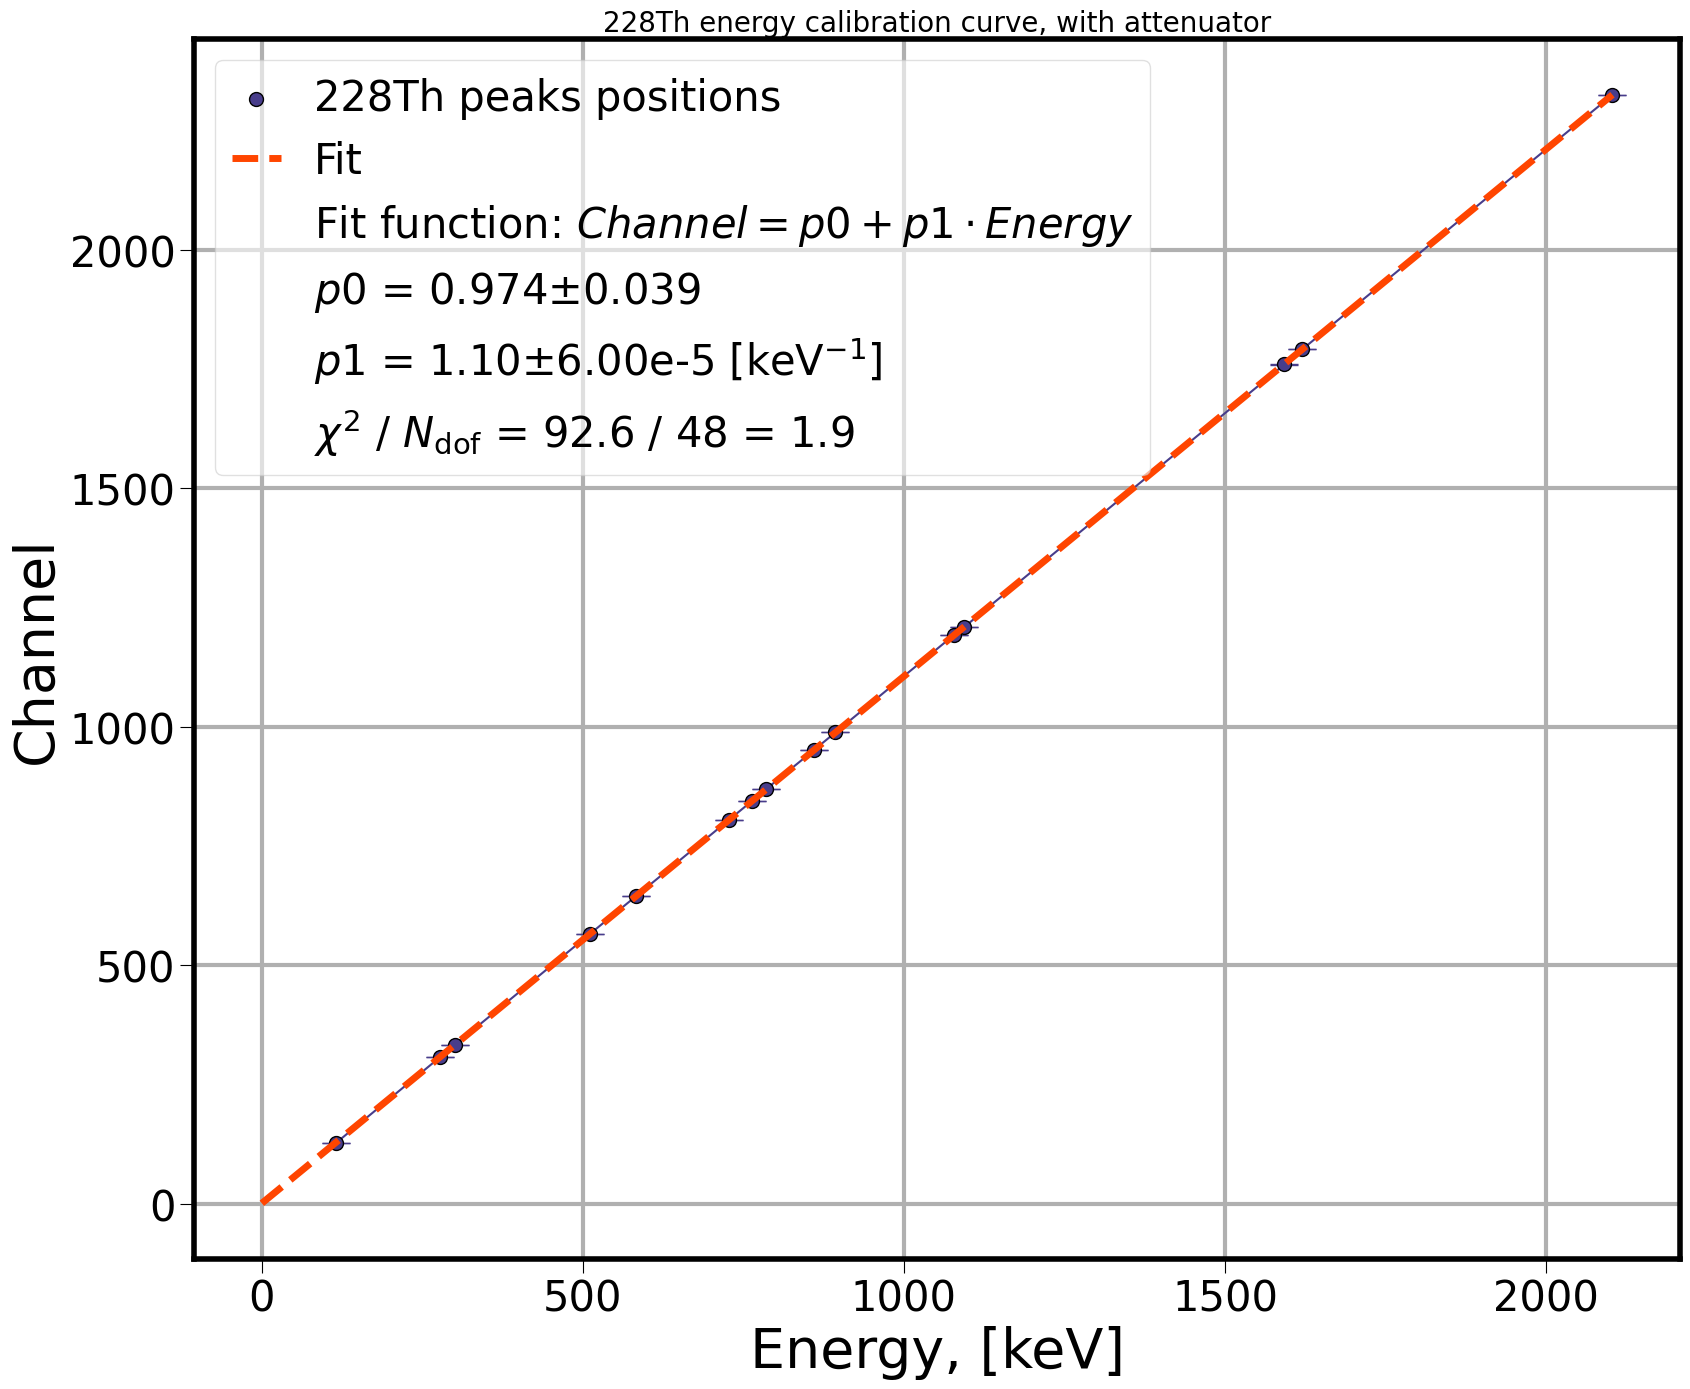

In [33]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th energy calibration curve, with attenuator', fontsize=20)




#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Channel", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()





handlelist=[]
labellist=[]


Data, = ax1.plot(Peak_energy, Peak_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Peak_channel, yerr=Peak_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Peak_channel, label=r'228Th peaks positions', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(data)
labellist.append(data.get_label())







#define fit function
def linear(x, p0, p1):
    return p0+p1*x





#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Peak_channel, Peak_channel_err,linear)




#set initial parameter values
p00=1.234
p10=1.1



#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)
    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1


Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}e-5'.format(round(Decimal(minuit.values['p1']),number_sigdigs(minuit.errors['p1'])), 
                                        round(Decimal(minuit.errors['p1']*1e5),number_sigdigs(minuit.errors['p1']*1e5)))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()

 

ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration.png", bbox_inches ='tight')
plt.show()


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th resolution calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Sigma, [Channel]')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.06 (χ²/ndof = 2.5)      │              Nfcn = 34               │
│ EDM = 8.77e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   1.26    │   0.04    │            │            │         │         │       │
│ 1 │ p1   │  0.40e-3  │  0.06e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │    0.00141 -2.1211e-6 │
│ p1 │ -2.1211e-6   3.48e-09 │
└────┴───────────────────────┘

<ValueView p0=1.2616961572410497 p1=0.00039949916945940765>
<ErrorView p0=0.03751244750173445 p1=5.9011838151575286e-05>
(1.2616961572410497, 0.00039949916945940765)


/tmp/ipykernel_23199/2609324062.py:206: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

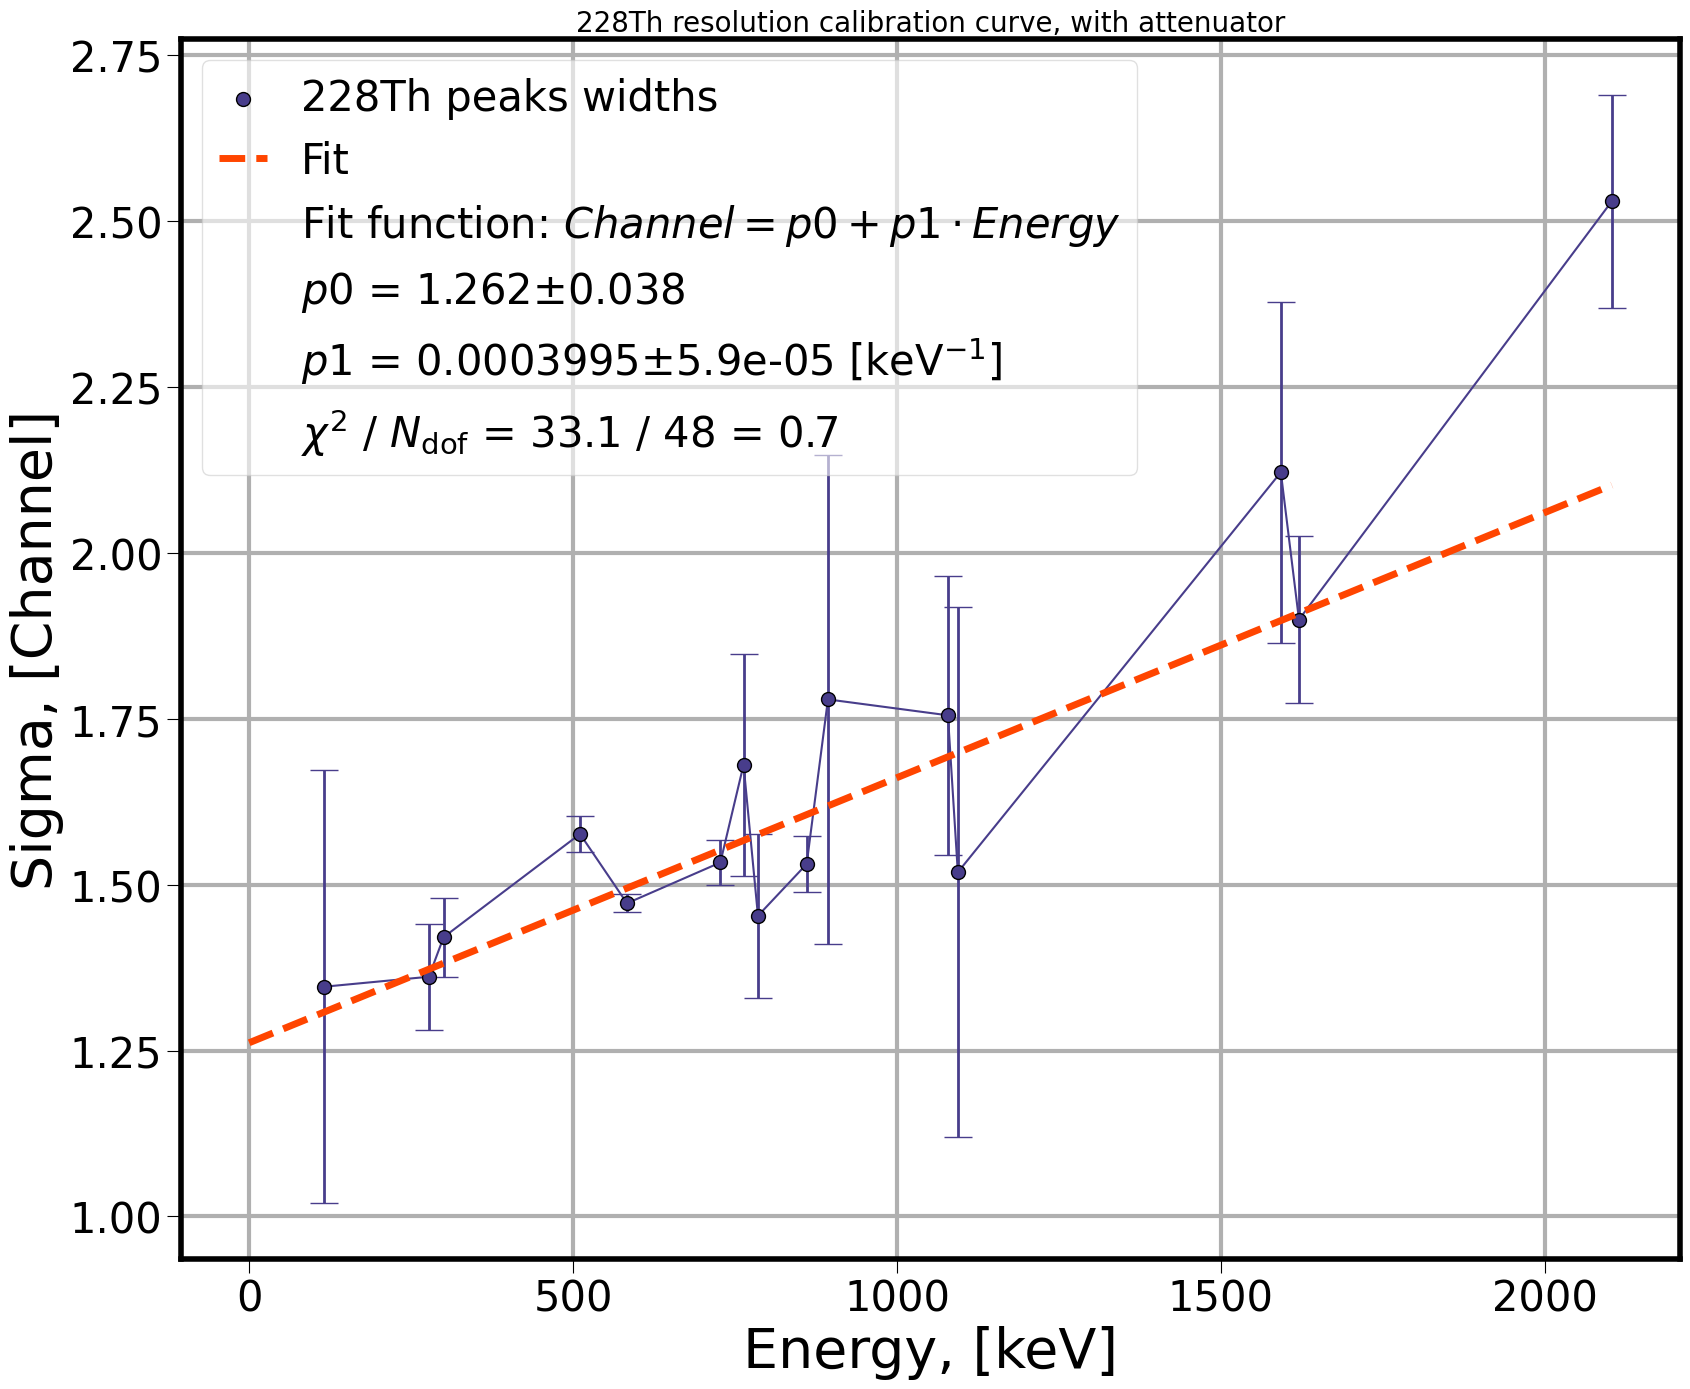

In [30]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th resolution calibration curve, with attenuator', fontsize=20)




#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Sigma, [Channel]", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()





handlelist=[]
labellist=[]


Data, = ax1.plot(Peak_energy, Sigma_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Sigma_channel, yerr=Sigma_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Sigma_channel, label=r'228Th peaks widths', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(data)
labellist.append(data.get_label())







#define fit function
def linear(x, p0, p1):
    return p0+p1*x





#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Sigma_channel, Sigma_channel_err,linear)




#set initial parameter values
p00=-0.41
p10=0.003



#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)

    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1


Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}'.format(round(minuit.values['p1'],7), round(minuit.errors['p1'],7))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()


ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration_sigma.png", bbox_inches ='tight')
plt.show()
